# WARNING
fenotag gpio=1st

# START

In [1]:
import pandas as pd
import numpy as np
import os
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS'] = '1'
import re
import ast
from itertools import product

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import DecisionBoundaryDisplay

# from keras.models import Sequential
# from keras.layers import Dense, Dropout
# from keras.utils import to_categorical
# from sklearn.metrics import classification_report, accuracy_score

# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, Input, Conv1D, MaxPooling1D, Flatten
# from keras.utils import to_categorical, set_random_seed

# from keras.optimizers import Adam
# from keras.callbacks import ModelCheckpoint, EarlyStopping

#
import tensorflow as tf
from keras.utils import set_random_seed, to_categorical
from keras.models import Sequential, Model
from keras.layers import (Dense, Dropout, Input, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D,
                          Flatten, Reshape, LSTM, SpatialDropout2D, BatchNormalization, concatenate)
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
from keras.constraints import max_norm
#

import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import json
from json import loads, dumps

from scipy.signal import find_peaks

In [2]:
import sklearn
sklearn.__version__

'1.6.1'

file.split('__')[-1].rstrip('.csv')

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
os.getcwd()

'/content'

In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [8]:
os.listdir()

['.config', 'drive', 'sample_data']

In [9]:
os.listdir('drive')

['.shortcut-targets-by-id', 'MyDrive', '.Trash-0', '.Encrypted']

In [10]:
os.listdir('drive/MyDrive/RTLS HQ')

['notebook', 'raw_data']

In [11]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [12]:
%cd 'drive/MyDrive/RTLS HQ'

/content/drive/MyDrive/RTLS HQ


In [13]:
os.listdir()

['notebook', 'raw_data']

# RFID data

## AcceliotIncHQ

In [14]:

Pathfiles_dict = {\

      'ConfID=2025-12-10__Item=cardboard__Qtags=20__antQ=8__Site=AcceliotIncHQ':\
      {'Reader=SF__Session=S?__Power=30dBm__Q=?':\
           [ 'id=2025-12-10'],\
      },\

                 }

In [15]:
RoundStart = pd.DataFrame()
gpio = pd.DataFrame()
Runs = []
tags = pd.DataFrame()
Actuals = pd.DataFrame()

for Conf in Pathfiles_dict.keys():
  print(Conf)
  for Reader in Pathfiles_dict[Conf].keys():
    print(Reader)
    settings_Conf_Reader = Conf + '__' + Reader
    # print(settings_Conf_Reader)
    for runID in Pathfiles_dict[Conf][Reader]:
      print(runID)
      settings_Conf_Reader_runID = settings_Conf_Reader + '__' + runID

      pathfile = os.path.join ('raw_data', Conf, Reader, runID)
      # print(os.listdir(pathfile))
      for file in os.listdir(pathfile):
        print(file)
        if file.endswith('txt'):
      # print(file)
          settings = settings_Conf_Reader_runID + '__' + file.rstrip('.txt')
          print(settings)
          settings = [x.split('=') for x in settings.split('__') ]
          print(settings)
          settings = {key:value for key, value in settings}
      # print(settings)
          filename = os.path.join(pathfile, file)
          errors_json=0
          counter_lines=0
          with open(filename, 'rt') as lines:
            run=0
            tags_run=[]
            RoundStart_run=[]
            gpio_run=[]

            for line in lines:
              if line.startswith('data: '):
                data_str = line.split('data: ')[1]
                try:
                  data_json = json.loads(data_str)
                  if run==0:
                    run=data_json['datestamp']
                    run=pd.to_datetime(run, format='%y/%m/%d %H:%M:%S.%f').round('1s')
                    print(run)
                    settings['run']=run

                  if data_json['type']=='RoundStart':
                    RoundStart_run.append(data_json)
                  if data_json['type']=='TagReadData':
                    tags_run.append(data_json)
                  if data_json['type']=='SensorData':
                    gpio_run.append(data_json)
                except:
                  errors_json += 1
        # print(tags_run)
            tags_run = pd.DataFrame(tags_run)
            tags_run['run'] = run
        # ConfID = settings['ConfID']
        # tags_run['ConfID'] = ConfID
    #
        # for key, value in settings.items():
        #   tags_run[key] = value

            Runs.append(settings)

            tags = pd.concat([tags, tags_run])
            RoundStart_run = pd.DataFrame(RoundStart_run)
            RoundStart_run['run'] = run
        # RoundStart_run['ConfID'] = ConfID
            RoundStart = pd.concat([RoundStart, RoundStart_run])
            gpio_run = pd.DataFrame(gpio_run)
            gpio_run['run'] = run
        # gpio_run['ConfID'] = ConfID
            gpio = pd.concat([gpio, gpio_run])

      print(errors_json)
  #
  # Actuals
  #
  pathfile_Actuals = os.path.join ('raw_data', Conf, 'Actuals')
  print(pathfile_Actuals)

  for file in os.listdir(pathfile_Actuals):
    print(file)
    filename = os.path.join(pathfile_Actuals, file)
    # Actuals_temp = pd.read_csv(filename, names=['EPC'], dtype=str)
    Actuals_temp = pd.read_csv(filename, dtype=str, sep=';')
    settings_temp = {x.split('=')[0] : x.split('=')[1]  for x in file.rstrip('.csv').split('__')}
    for key, value in settings_temp.items():
      Actuals_temp[key] = value
    ConfID=settings['ConfID']
    Actuals_temp['ConfID']=ConfID
    Actuals = pd.concat([Actuals, Actuals_temp])
  print(Actuals.shape)
  #
  # antConf
  #
  pathfile_antConf = os.path.join ('raw_data', Conf, 'antConf')
  filename = os.path.join(pathfile_antConf, 'antConf=HQ.csv')
  antConf = pd.read_csv(filename, sep=';')
  print(antConf.shape)


ConfID=2025-12-10__Item=cardboard__Qtags=20__antQ=8__Site=AcceliotIncHQ
Reader=SF__Session=S?__Power=30dBm__Q=?
id=2025-12-10
test=proto.txt
ConfID=2025-12-10__Item=cardboard__Qtags=20__antQ=8__Site=AcceliotIncHQ__Reader=SF__Session=S?__Power=30dBm__Q=?__id=2025-12-10__test=proto
[['ConfID', '2025-12-10'], ['Item', 'cardboard'], ['Qtags', '20'], ['antQ', '8'], ['Site', 'AcceliotIncHQ'], ['Reader', 'SF'], ['Session', 'S?'], ['Power', '30dBm'], ['Q', '?'], ['id', '2025-12-10'], ['test', 'proto']]
2025-12-10 17:33:03
1
raw_data/ConfID=2025-12-10__Item=cardboard__Qtags=20__antQ=8__Site=AcceliotIncHQ/Actuals
actual=P.csv
(17, 6)
(8, 4)


raw RFID: tags, Runs, gpio

In [16]:
Runs = pd.DataFrame(Runs)
Runs

,ConfID,Item,Qtags,antQ,Site,Reader,Session,Power,Q,id,test,run
0,2025-12-10,cardboard,20,8,AcceliotIncHQ,SF,S?,30dBm,?,2025-12-10,proto,2025-12-10 17:33:03


In [17]:
tags.shape, tags['run'].nunique()

((97502, 18), 1)

In [18]:
antConf

,antennaID,x,y,z
0,041A9F60,9.2,7.2,11.9
1,041A9F61,9.1,12.6,11.9
2,PORT_1,19.1,13.2,13.1
3,PORT_2,28.2,12.6,13.0
4,PORT_3,18.7,5.5,13.1
5,PORT_4,28.1,6.9,13.0
6,0F17B312,36.6,5.5,13.8
7,0F17B313,37.2,13.2,14.2


In [19]:
Actuals['x'] = Actuals['x'].astype(float)
Actuals['y'] = Actuals['y'].astype(float)
Actuals['z'] = Actuals['z'].astype(float)

In [20]:
Actuals.head()

,EPC,x,y,z,actual,ConfID
0,ACC102,6.7,11.7,5.3,P,2025-12-10
1,ACC103,11.0,18.3,8.6,P,2025-12-10
2,ACC104,15.4,7.2,6.9,P,2025-12-10
3,ACC105,21.2,10.4,2.1,P,2025-12-10
4,ACC106,26.1,18.1,4.6,P,2025-12-10


# Actuals

In [21]:
# Add a dummy column to both DataFrames for a Cartesian product
Actuals['key'] = 1
antConf['key'] = 1

# Rename columns in antConf to avoid conflicts during the merge
antConf_renamed = antConf.rename(columns={'x': 'x_ant', 'y': 'y_ant', 'z': 'z_ant'})

# Perform a Cartesian product (full outer join on the dummy key)
# Use the renamed antConf_renamed DataFrame
Actuals = pd.merge(Actuals, antConf_renamed, on='key')

# Drop the dummy key column
Actuals = Actuals.drop('key', axis=1)

# Display the head of the resulting DataFrame
Actuals

,EPC,x,y,z,actual,ConfID,antennaID,x_ant,y_ant,z_ant
0,ACC102,6.7,11.7,5.3,P,2025-12-10,041A9F60,9.2,7.2,11.9
1,ACC102,6.7,11.7,5.3,P,2025-12-10,041A9F61,9.1,12.6,11.9
2,ACC102,6.7,11.7,5.3,P,2025-12-10,PORT_1,19.1,13.2,13.1
3,ACC102,6.7,11.7,5.3,P,2025-12-10,PORT_2,28.2,12.6,13.0
4,ACC102,6.7,11.7,5.3,P,2025-12-10,PORT_3,18.7,5.5,13.1
...,...,...,...,...,...,...,...,...,...,...
131,ACC120,8.3,7.2,6.9,P,2025-12-10,PORT_2,28.2,12.6,13.0
132,ACC120,8.3,7.2,6.9,P,2025-12-10,PORT_3,18.7,5.5,13.1
133,ACC120,8.3,7.2,6.9,P,2025-12-10,PORT_4,28.1,6.9,13.0
134,ACC120,8.3,7.2,6.9,P,2025-12-10,0F17B312,36.6,5.5,13.8


In [22]:
xyz_EPC=['x', 'y', 'z']
xyz_ant=['x_ant', 'y_ant', 'z_ant']
Actuals['D'] = [np.sqrt((x**2).sum()) for x in Actuals[xyz_EPC].values - Actuals[xyz_ant].values]
Actuals.head()

,EPC,x,y,z,actual,ConfID,antennaID,x_ant,y_ant,z_ant,D
0,ACC102,6.7,11.7,5.3,P,2025-12-10,041A9F60,9.2,7.2,11.9,8.370185
1,ACC102,6.7,11.7,5.3,P,2025-12-10,041A9F61,9.1,12.6,11.9,7.080254
2,ACC102,6.7,11.7,5.3,P,2025-12-10,PORT_1,19.1,13.2,13.1,14.725828
3,ACC102,6.7,11.7,5.3,P,2025-12-10,PORT_2,28.2,12.6,13.0,22.854978
4,ACC102,6.7,11.7,5.3,P,2025-12-10,PORT_3,18.7,5.5,13.1,15.597436


In [23]:
Actuals = Actuals.pivot_table(index=['EPC', 'x', 'y', 'z', 'actual', 'ConfID'], columns='antennaID', values='D')

# Flatten the column names if necessary (after pivoting, columns might be multi-level)
Cols_D = ['D_' + str(col) for col in Actuals.columns]
Actuals.columns = Cols_D


Actuals = Actuals.reset_index()
Actuals.head()

,EPC,x,y,z,actual,ConfID,D_041A9F60,D_041A9F61,D_0F17B312,D_0F17B313,D_PORT_1,D_PORT_2,D_PORT_3,D_PORT_4
0,ACC102,6.7,11.7,5.3,P,2025-12-10,8.370185,7.080254,31.697003,31.807389,14.725828,22.854978,15.597436,23.244139
1,ACC103,11.0,18.3,8.6,P,2025-12-10,11.719215,6.854925,29.090205,27.272880,10.576862,18.646447,15.600641,21.017374
2,ACC104,15.4,7.2,6.9,P,2025-12-10,7.964923,9.687621,22.359338,23.759840,9.387758,15.172673,7.226341,14.092196
3,ACC105,21.2,10.4,2.1,P,2025-12-10,15.820240,15.725457,19.951441,20.254629,11.543396,13.139635,12.298780,13.366750
4,ACC106,26.1,18.1,4.6,P,2025-12-10,21.394158,19.301295,18.805584,15.471910,12.052386,10.257680,16.904733,14.142136


In [24]:
 Actuals ['nearestAnt'] = Actuals[Cols_D].idxmin(axis=1).str.split('D_').str[-1]
 Actuals.head()
 Actuals

,EPC,x,y,z,actual,ConfID,D_041A9F60,D_041A9F61,D_0F17B312,D_0F17B313,D_PORT_1,D_PORT_2,D_PORT_3,D_PORT_4,nearestAnt
0,ACC102,6.7,11.7,5.3,P,2025-12-10,8.370185,7.080254,31.697003,31.807389,14.725828,22.854978,15.597436,23.244139,041A9F61
1,ACC103,11.0,18.3,8.6,P,2025-12-10,11.719215,6.854925,29.090205,27.272880,10.576862,18.646447,15.600641,21.017374,041A9F61
2,ACC104,15.4,7.2,6.9,P,2025-12-10,7.964923,9.687621,22.359338,23.759840,9.387758,15.172673,7.226341,14.092196,PORT_3
3,ACC105,21.2,10.4,2.1,P,2025-12-10,15.820240,15.725457,19.951441,20.254629,11.543396,13.139635,12.298780,13.366750,PORT_1
4,ACC106,26.1,18.1,4.6,P,2025-12-10,21.394158,19.301295,18.805584,15.471910,12.052386,10.257680,16.904733,14.142136,PORT_2
5,ACC107,29.4,6.9,7.6,P,2025-12-10,20.654782,21.519061,9.604166,12.003749,13.267630,7.942921,12.111978,5.554278,PORT_4
6,ACC108,27.9,19.6,6.8,P,2025-12-10,23.009998,20.699034,17.986106,13.498518,12.573385,9.355747,17.976095,14.134002,PORT_2
7,ACC109,0.0,10.4,5.6,P,2025-12-10,11.600431,11.284503,37.826049,38.283678,20.709901,29.237647,20.735236,29.268071,041A9F61
8,ACC110,10.4,1.5,5.6,P,2025-12-10,8.580210,12.829263,27.743107,30.480978,16.396036,22.244325,11.880236,19.930128,041A9F60
9,ACC112,35.1,8.1,5.0,P,2025-12-10,26.818464,27.273797,9.297849,10.726602,18.644570,11.483031,18.475118,10.697663,0F17B312


# tags

RoundStart rxAntennaConfig

In [25]:
RoundStart['rxAntennaConfig'] = RoundStart['rxAntennaConfig'].apply(lambda x: [value for key, value in x.items() if value!='NONE'])
RoundStart.head()

,type,timestamp,datestamp,seqNum,inventoryCycleCount,round,freq_MHz,jurisdiction,txAntennaPort,txExpanderPort,transmitSource,txPower_dBm,rxAntennaConfig,validBackchannel,run
0,RoundStart,1765387982666,25/12/10 17:33:02.666,191826707,71052,35008607,922.75,US,041A9F61,NONE,ENM_3004,31.5,"[PORT_3, PORT_4]",1,2025-12-10 17:33:03
1,RoundStart,1765387982716,25/12/10 17:33:02.716,191826717,71052,35008608,914.25,US,PORT_3,NONE,INTERNAL,31.5,"[PORT_3, PORT_4]",-1,2025-12-10 17:33:03
2,RoundStart,1765387982837,25/12/10 17:33:02.837,191826739,71052,35008609,914.75,US,PORT_4,NONE,INTERNAL,31.5,"[PORT_4, PORT_3]",-1,2025-12-10 17:33:03
3,RoundStart,1765387982955,25/12/10 17:33:02.955,191826756,71052,35008610,905.25,US,PORT_1,NONE,INTERNAL,31.5,"[PORT_1, PORT_3]",-1,2025-12-10 17:33:03
4,RoundStart,1765387983076,25/12/10 17:33:03.076,191826772,71052,35008611,915.25,US,PORT_2,NONE,INTERNAL,31.5,"[PORT_2, PORT_3]",-1,2025-12-10 17:33:03


merge tags, RoundStart

In [26]:
def func(df):
  run = df['run'].values[0]
  RoundStart_run = RoundStart [ RoundStart['run'] == run]
  df = pd.merge(df, RoundStart_run[['round', 'rxAntennaConfig', 'txPower_dBm', 'freq_MHz']], on='round')
  return df
tags = tags.groupby('run').apply(func).reset_index(drop=True)
tags.head()

/tmp/ipython-input-3865696018.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tags = tags.groupby('run').apply(func).reset_index(drop=True)


,type,timestamp,datestamp,seqNum,round,txAntennaPort,txExpanderPort,transmitSource,rssi,preambleQuality,...,vgaValues,numBits,rxPhasors,digitalGain,data,alias,run,rxAntennaConfig,txPower_dBm,freq_MHz
0,TagReadData,1765387982668,25/12/10 17:33:02.668,191826708,35008607,041A9F61,NONE,ENM_3004,"[-61.56, -88.73]",10192,...,"[221, 164]",128,"[[32767, -791], [-6280, -6852]]",6.430130,0x30AE1A72B42CD079A48E68E23E236573,41A9F6:1,2025-12-10 17:33:03,"[PORT_3, PORT_4]",31.5,922.75
1,TagReadData,1765387982668,25/12/10 17:33:02.668,191826709,35008607,041A9F61,NONE,ENM_3004,"[-71.31, -73.54]",5871,...,"[232, 144]",128,"[[-9506, -20250], [4431, -32288]]",11.162659,0x3400ABACAB020202020202020202FF53,41A9F6:1,2025-12-10 17:33:03,"[PORT_3, PORT_4]",31.5,922.75
2,TagReadData,1765387982669,25/12/10 17:33:02.669,191826710,35008607,041A9F61,NONE,ENM_3004,"[-74.06, -69.88]",5957,...,"[232, 136]",128,"[[5704, 15000], [-4698, 32173]]",11.001511,0x3400ACC120000000000000ACC120C7B4,41A9F6:1,2025-12-10 17:33:03,"[PORT_3, PORT_4]",31.5,922.75
3,TagReadData,1765387982676,25/12/10 17:33:02.676,191826711,35008607,041A9F61,NONE,ENM_3004,"[-73.16, -77.07]",5875,...,"[232, 152]",128,"[[-14770, 11472], [20469, 25639]]",11.155060,0x3400ACC116000000000000ACC1164F05,41A9F6:1,2025-12-10 17:33:03,"[PORT_3, PORT_4]",31.5,922.75
4,TagReadData,1765387982677,25/12/10 17:33:02.677,191826712,35008607,041A9F61,NONE,ENM_3004,"[-76.97, -83.07]",5415,...,"[237, 164]",160,"[[-11982, 7642], [26759, -17767]]",12.102676,0x40000838530DEEAC1B172DF2EA558B6084000D5B,41A9F6:1,2025-12-10 17:33:03,"[PORT_3, PORT_4]",31.5,922.75


stacked data

In [27]:
# tags = tags.explode('rssi')
RSSI = tags['rssi'].apply(lambda x:pd.Series(x)).stack().rename('RSSI (dBm)').reset_index(1, drop=True)
RSSI.head()

,RSSI (dBm)
0,-61.56
0,-88.73
1,-71.31
1,-73.54
2,-74.06


In [28]:
Rx = tags['rxAntennaConfig'].apply(lambda x:pd.Series(x)).stack().rename('Rx').reset_index(1, drop=True)
Rx.head()

,Rx
0,PORT_3
0,PORT_4
1,PORT_3
1,PORT_4
2,PORT_3


In [29]:
stacked_data = pd.concat([Rx, RSSI], axis=1)
# stacked_data = pd.concat([Rx, RSSI, rxPhasors], axis=1)
# stacked_data = pd.concat([Rx, RSSI, rxPhasors, Delta_Phases], axis=1)
# stacked_data = pd.concat([Rx, RSSI, rxPhasors, vgaValues], axis=1)

stacked_data.head()

,Rx,RSSI (dBm)
0,PORT_3,-61.56
0,PORT_4,-88.73
1,PORT_3,-71.31
1,PORT_4,-73.54
2,PORT_3,-74.06


In [30]:
tags = tags.join(stacked_data)
tags.head()

,type,timestamp,datestamp,seqNum,round,txAntennaPort,txExpanderPort,transmitSource,rssi,preambleQuality,...,rxPhasors,digitalGain,data,alias,run,rxAntennaConfig,txPower_dBm,freq_MHz,Rx,RSSI (dBm)
0,TagReadData,1765387982668,25/12/10 17:33:02.668,191826708,35008607,041A9F61,NONE,ENM_3004,"[-61.56, -88.73]",10192,...,"[[32767, -791], [-6280, -6852]]",6.430130,0x30AE1A72B42CD079A48E68E23E236573,41A9F6:1,2025-12-10 17:33:03,"[PORT_3, PORT_4]",31.5,922.75,PORT_3,-61.56
0,TagReadData,1765387982668,25/12/10 17:33:02.668,191826708,35008607,041A9F61,NONE,ENM_3004,"[-61.56, -88.73]",10192,...,"[[32767, -791], [-6280, -6852]]",6.430130,0x30AE1A72B42CD079A48E68E23E236573,41A9F6:1,2025-12-10 17:33:03,"[PORT_3, PORT_4]",31.5,922.75,PORT_4,-88.73
1,TagReadData,1765387982668,25/12/10 17:33:02.668,191826709,35008607,041A9F61,NONE,ENM_3004,"[-71.31, -73.54]",5871,...,"[[-9506, -20250], [4431, -32288]]",11.162659,0x3400ABACAB020202020202020202FF53,41A9F6:1,2025-12-10 17:33:03,"[PORT_3, PORT_4]",31.5,922.75,PORT_3,-71.31
1,TagReadData,1765387982668,25/12/10 17:33:02.668,191826709,35008607,041A9F61,NONE,ENM_3004,"[-71.31, -73.54]",5871,...,"[[-9506, -20250], [4431, -32288]]",11.162659,0x3400ABACAB020202020202020202FF53,41A9F6:1,2025-12-10 17:33:03,"[PORT_3, PORT_4]",31.5,922.75,PORT_4,-73.54
2,TagReadData,1765387982669,25/12/10 17:33:02.669,191826710,35008607,041A9F61,NONE,ENM_3004,"[-74.06, -69.88]",5957,...,"[[5704, 15000], [-4698, 32173]]",11.001511,0x3400ACC120000000000000ACC120C7B4,41A9F6:1,2025-12-10 17:33:03,"[PORT_3, PORT_4]",31.5,922.75,PORT_3,-74.06


RSSI linear

In [31]:
tags['RSSI']=10**6 * 10**(tags['RSSI (dBm)']/10)
tags.head()

,type,timestamp,datestamp,seqNum,round,txAntennaPort,txExpanderPort,transmitSource,rssi,preambleQuality,...,digitalGain,data,alias,run,rxAntennaConfig,txPower_dBm,freq_MHz,Rx,RSSI (dBm),RSSI
0,TagReadData,1765387982668,25/12/10 17:33:02.668,191826708,35008607,041A9F61,NONE,ENM_3004,"[-61.56, -88.73]",10192,...,6.430130,0x30AE1A72B42CD079A48E68E23E236573,41A9F6:1,2025-12-10 17:33:03,"[PORT_3, PORT_4]",31.5,922.75,PORT_3,-61.56,0.698232
0,TagReadData,1765387982668,25/12/10 17:33:02.668,191826708,35008607,041A9F61,NONE,ENM_3004,"[-61.56, -88.73]",10192,...,6.430130,0x30AE1A72B42CD079A48E68E23E236573,41A9F6:1,2025-12-10 17:33:03,"[PORT_3, PORT_4]",31.5,922.75,PORT_4,-88.73,0.001340
1,TagReadData,1765387982668,25/12/10 17:33:02.668,191826709,35008607,041A9F61,NONE,ENM_3004,"[-71.31, -73.54]",5871,...,11.162659,0x3400ABACAB020202020202020202FF53,41A9F6:1,2025-12-10 17:33:03,"[PORT_3, PORT_4]",31.5,922.75,PORT_3,-71.31,0.073961
1,TagReadData,1765387982668,25/12/10 17:33:02.668,191826709,35008607,041A9F61,NONE,ENM_3004,"[-71.31, -73.54]",5871,...,11.162659,0x3400ABACAB020202020202020202FF53,41A9F6:1,2025-12-10 17:33:03,"[PORT_3, PORT_4]",31.5,922.75,PORT_4,-73.54,0.044259
2,TagReadData,1765387982669,25/12/10 17:33:02.669,191826710,35008607,041A9F61,NONE,ENM_3004,"[-74.06, -69.88]",5957,...,11.001511,0x3400ACC120000000000000ACC120C7B4,41A9F6:1,2025-12-10 17:33:03,"[PORT_3, PORT_4]",31.5,922.75,PORT_3,-74.06,0.039264


reset_index

In [32]:
tags = tags.reset_index(drop=True)
tags.head()

,type,timestamp,datestamp,seqNum,round,txAntennaPort,txExpanderPort,transmitSource,rssi,preambleQuality,...,digitalGain,data,alias,run,rxAntennaConfig,txPower_dBm,freq_MHz,Rx,RSSI (dBm),RSSI
0,TagReadData,1765387982668,25/12/10 17:33:02.668,191826708,35008607,041A9F61,NONE,ENM_3004,"[-61.56, -88.73]",10192,...,6.430130,0x30AE1A72B42CD079A48E68E23E236573,41A9F6:1,2025-12-10 17:33:03,"[PORT_3, PORT_4]",31.5,922.75,PORT_3,-61.56,0.698232
1,TagReadData,1765387982668,25/12/10 17:33:02.668,191826708,35008607,041A9F61,NONE,ENM_3004,"[-61.56, -88.73]",10192,...,6.430130,0x30AE1A72B42CD079A48E68E23E236573,41A9F6:1,2025-12-10 17:33:03,"[PORT_3, PORT_4]",31.5,922.75,PORT_4,-88.73,0.001340
2,TagReadData,1765387982668,25/12/10 17:33:02.668,191826709,35008607,041A9F61,NONE,ENM_3004,"[-71.31, -73.54]",5871,...,11.162659,0x3400ABACAB020202020202020202FF53,41A9F6:1,2025-12-10 17:33:03,"[PORT_3, PORT_4]",31.5,922.75,PORT_3,-71.31,0.073961
3,TagReadData,1765387982668,25/12/10 17:33:02.668,191826709,35008607,041A9F61,NONE,ENM_3004,"[-71.31, -73.54]",5871,...,11.162659,0x3400ABACAB020202020202020202FF53,41A9F6:1,2025-12-10 17:33:03,"[PORT_3, PORT_4]",31.5,922.75,PORT_4,-73.54,0.044259
4,TagReadData,1765387982669,25/12/10 17:33:02.669,191826710,35008607,041A9F61,NONE,ENM_3004,"[-74.06, -69.88]",5957,...,11.001511,0x3400ACC120000000000000ACC120C7B4,41A9F6:1,2025-12-10 17:33:03,"[PORT_3, PORT_4]",31.5,922.75,PORT_3,-74.06,0.039264


In [33]:
tags.shape

(195004, 24)

In [34]:
tags = tags.rename(columns={'txAntennaPort':'Tx'})
tags.head()

,type,timestamp,datestamp,seqNum,round,Tx,txExpanderPort,transmitSource,rssi,preambleQuality,...,digitalGain,data,alias,run,rxAntennaConfig,txPower_dBm,freq_MHz,Rx,RSSI (dBm),RSSI
0,TagReadData,1765387982668,25/12/10 17:33:02.668,191826708,35008607,041A9F61,NONE,ENM_3004,"[-61.56, -88.73]",10192,...,6.430130,0x30AE1A72B42CD079A48E68E23E236573,41A9F6:1,2025-12-10 17:33:03,"[PORT_3, PORT_4]",31.5,922.75,PORT_3,-61.56,0.698232
1,TagReadData,1765387982668,25/12/10 17:33:02.668,191826708,35008607,041A9F61,NONE,ENM_3004,"[-61.56, -88.73]",10192,...,6.430130,0x30AE1A72B42CD079A48E68E23E236573,41A9F6:1,2025-12-10 17:33:03,"[PORT_3, PORT_4]",31.5,922.75,PORT_4,-88.73,0.001340
2,TagReadData,1765387982668,25/12/10 17:33:02.668,191826709,35008607,041A9F61,NONE,ENM_3004,"[-71.31, -73.54]",5871,...,11.162659,0x3400ABACAB020202020202020202FF53,41A9F6:1,2025-12-10 17:33:03,"[PORT_3, PORT_4]",31.5,922.75,PORT_3,-71.31,0.073961
3,TagReadData,1765387982668,25/12/10 17:33:02.668,191826709,35008607,041A9F61,NONE,ENM_3004,"[-71.31, -73.54]",5871,...,11.162659,0x3400ABACAB020202020202020202FF53,41A9F6:1,2025-12-10 17:33:03,"[PORT_3, PORT_4]",31.5,922.75,PORT_4,-73.54,0.044259
4,TagReadData,1765387982669,25/12/10 17:33:02.669,191826710,35008607,041A9F61,NONE,ENM_3004,"[-74.06, -69.88]",5957,...,11.001511,0x3400ACC120000000000000ACC120C7B4,41A9F6:1,2025-12-10 17:33:03,"[PORT_3, PORT_4]",31.5,922.75,PORT_3,-74.06,0.039264


datestamp; warning y because 24 for 2024

In [35]:
tags['datestamp'] = pd.to_datetime(tags['datestamp'], format='%y/%m/%d %H:%M:%S.%f')
tags.head()

,type,timestamp,datestamp,seqNum,round,Tx,txExpanderPort,transmitSource,rssi,preambleQuality,...,digitalGain,data,alias,run,rxAntennaConfig,txPower_dBm,freq_MHz,Rx,RSSI (dBm),RSSI
0,TagReadData,1765387982668,2025-12-10 17:33:02.668,191826708,35008607,041A9F61,NONE,ENM_3004,"[-61.56, -88.73]",10192,...,6.430130,0x30AE1A72B42CD079A48E68E23E236573,41A9F6:1,2025-12-10 17:33:03,"[PORT_3, PORT_4]",31.5,922.75,PORT_3,-61.56,0.698232
1,TagReadData,1765387982668,2025-12-10 17:33:02.668,191826708,35008607,041A9F61,NONE,ENM_3004,"[-61.56, -88.73]",10192,...,6.430130,0x30AE1A72B42CD079A48E68E23E236573,41A9F6:1,2025-12-10 17:33:03,"[PORT_3, PORT_4]",31.5,922.75,PORT_4,-88.73,0.001340
2,TagReadData,1765387982668,2025-12-10 17:33:02.668,191826709,35008607,041A9F61,NONE,ENM_3004,"[-71.31, -73.54]",5871,...,11.162659,0x3400ABACAB020202020202020202FF53,41A9F6:1,2025-12-10 17:33:03,"[PORT_3, PORT_4]",31.5,922.75,PORT_3,-71.31,0.073961
3,TagReadData,1765387982668,2025-12-10 17:33:02.668,191826709,35008607,041A9F61,NONE,ENM_3004,"[-71.31, -73.54]",5871,...,11.162659,0x3400ABACAB020202020202020202FF53,41A9F6:1,2025-12-10 17:33:03,"[PORT_3, PORT_4]",31.5,922.75,PORT_4,-73.54,0.044259
4,TagReadData,1765387982669,2025-12-10 17:33:02.669,191826710,35008607,041A9F61,NONE,ENM_3004,"[-74.06, -69.88]",5957,...,11.001511,0x3400ACC120000000000000ACC120C7B4,41A9F6:1,2025-12-10 17:33:03,"[PORT_3, PORT_4]",31.5,922.75,PORT_3,-74.06,0.039264


# EPC

# WARNING universal ??

In [36]:
tags['EPC'] = tags['data'].apply(lambda x:x[6:30])
tags.head()

,type,timestamp,datestamp,seqNum,round,Tx,txExpanderPort,transmitSource,rssi,preambleQuality,...,data,alias,run,rxAntennaConfig,txPower_dBm,freq_MHz,Rx,RSSI (dBm),RSSI,EPC
0,TagReadData,1765387982668,2025-12-10 17:33:02.668,191826708,35008607,041A9F61,NONE,ENM_3004,"[-61.56, -88.73]",10192,...,0x30AE1A72B42CD079A48E68E23E236573,41A9F6:1,2025-12-10 17:33:03,"[PORT_3, PORT_4]",31.5,922.75,PORT_3,-61.56,0.698232,1A72B42CD079A48E68E23E23
1,TagReadData,1765387982668,2025-12-10 17:33:02.668,191826708,35008607,041A9F61,NONE,ENM_3004,"[-61.56, -88.73]",10192,...,0x30AE1A72B42CD079A48E68E23E236573,41A9F6:1,2025-12-10 17:33:03,"[PORT_3, PORT_4]",31.5,922.75,PORT_4,-88.73,0.001340,1A72B42CD079A48E68E23E23
2,TagReadData,1765387982668,2025-12-10 17:33:02.668,191826709,35008607,041A9F61,NONE,ENM_3004,"[-71.31, -73.54]",5871,...,0x3400ABACAB020202020202020202FF53,41A9F6:1,2025-12-10 17:33:03,"[PORT_3, PORT_4]",31.5,922.75,PORT_3,-71.31,0.073961,ABACAB020202020202020202
3,TagReadData,1765387982668,2025-12-10 17:33:02.668,191826709,35008607,041A9F61,NONE,ENM_3004,"[-71.31, -73.54]",5871,...,0x3400ABACAB020202020202020202FF53,41A9F6:1,2025-12-10 17:33:03,"[PORT_3, PORT_4]",31.5,922.75,PORT_4,-73.54,0.044259,ABACAB020202020202020202
4,TagReadData,1765387982669,2025-12-10 17:33:02.669,191826710,35008607,041A9F61,NONE,ENM_3004,"[-74.06, -69.88]",5957,...,0x3400ACC120000000000000ACC120C7B4,41A9F6:1,2025-12-10 17:33:03,"[PORT_3, PORT_4]",31.5,922.75,PORT_3,-74.06,0.039264,ACC120000000000000ACC120


In [37]:
tags['EPC'].nunique()

274

In [38]:
tags = tags [['run', 'EPC', 'datestamp', 'Tx', 'Rx', 'RSSI (dBm)', 'RSSI']]
tags.head()

,run,EPC,datestamp,Tx,Rx,RSSI (dBm),RSSI
0,2025-12-10 17:33:03,1A72B42CD079A48E68E23E23,2025-12-10 17:33:02.668,041A9F61,PORT_3,-61.56,0.698232
1,2025-12-10 17:33:03,1A72B42CD079A48E68E23E23,2025-12-10 17:33:02.668,041A9F61,PORT_4,-88.73,0.001340
2,2025-12-10 17:33:03,ABACAB020202020202020202,2025-12-10 17:33:02.668,041A9F61,PORT_3,-71.31,0.073961
3,2025-12-10 17:33:03,ABACAB020202020202020202,2025-12-10 17:33:02.668,041A9F61,PORT_4,-73.54,0.044259
4,2025-12-10 17:33:03,ACC120000000000000ACC120,2025-12-10 17:33:02.669,041A9F61,PORT_3,-74.06,0.039264


## EPC in Accelio HQ

In [39]:
tags = tags [tags['EPC'].str.startswith('ACC1')]
tags['EPC_sf'] = tags['EPC']
tags.head()
tags['EPC'] = 'ACC1' + tags['EPC'].str.split('ACC1').str[-1]
tags.head()


,run,EPC,datestamp,Tx,Rx,RSSI (dBm),RSSI,EPC_sf
4,2025-12-10 17:33:03,ACC120,2025-12-10 17:33:02.669,041A9F61,PORT_3,-74.06,0.039264,ACC120000000000000ACC120
5,2025-12-10 17:33:03,ACC120,2025-12-10 17:33:02.669,041A9F61,PORT_4,-69.88,0.102802,ACC120000000000000ACC120
6,2025-12-10 17:33:03,ACC116,2025-12-10 17:33:02.676,041A9F61,PORT_3,-73.16,0.048306,ACC116000000000000ACC116
7,2025-12-10 17:33:03,ACC116,2025-12-10 17:33:02.676,041A9F61,PORT_4,-77.07,0.019634,ACC116000000000000ACC116
16,2025-12-10 17:33:03,ACC102,2025-12-10 17:33:02.715,041A9F61,PORT_3,-64.79,0.331894,ACC102000000000000ACC102


In [40]:
tags['EPC'].nunique()

18

# Slots

WARNING freq

In [41]:
freq='1000ms' # '750ms' '1000ms' '1500ms' '2000ms'

In [42]:
def func(df):
    Tmin = df['datestamp'].min()
    Tmax = df['datestamp'].max()
    Slots = pd.DataFrame({'slotStart':pd.date_range(start=Tmin, end=Tmax, freq=freq)})
#     Slots['slot_id']=range(len(Slots))
    return Slots

Slots = tags.groupby('run').apply(func).reset_index(drop=False).rename(columns={'level_1':'slot_id'})
Slots['slot_id'] = Slots['slot_id'].astype('int32')
Slots.head()

/tmp/ipython-input-825973545.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Slots = tags.groupby('run').apply(func).reset_index(drop=False).rename(columns={'level_1':'slot_id'})


,run,slot_id,slotStart
0,2025-12-10 17:33:03,0,2025-12-10 17:33:02.669
1,2025-12-10 17:33:03,1,2025-12-10 17:33:03.669
2,2025-12-10 17:33:03,2,2025-12-10 17:33:04.669
3,2025-12-10 17:33:03,3,2025-12-10 17:33:05.669
4,2025-12-10 17:33:03,4,2025-12-10 17:33:06.669


In [43]:
Slots.groupby('run').size()

,0
run,
2025-12-10 17:33:03,759


# merge_asof tags Slots

In [44]:
def func(x):
  run=x['run'].values[0]
  # print(run)
  Slots_run = Slots [ Slots['run']==run ]
  x=x.sort_values('datestamp', ascending=True)
  Slots_run=Slots_run.sort_values('slotStart', ascending=True)
  x = pd.merge_asof(x, Slots_run.drop(columns=['run']) , left_on='datestamp', right_on='slotStart', direction='nearest')
  return x

tags = tags.groupby('run', group_keys=False).apply(func).reset_index(drop=True)
tags.head()

/tmp/ipython-input-3839639129.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tags = tags.groupby('run', group_keys=False).apply(func).reset_index(drop=True)


,run,EPC,datestamp,Tx,Rx,RSSI (dBm),RSSI,EPC_sf,slot_id,slotStart
0,2025-12-10 17:33:03,ACC120,2025-12-10 17:33:02.669,041A9F61,PORT_3,-74.06,0.039264,ACC120000000000000ACC120,0,2025-12-10 17:33:02.669
1,2025-12-10 17:33:03,ACC120,2025-12-10 17:33:02.669,041A9F61,PORT_4,-69.88,0.102802,ACC120000000000000ACC120,0,2025-12-10 17:33:02.669
2,2025-12-10 17:33:03,ACC116,2025-12-10 17:33:02.676,041A9F61,PORT_3,-73.16,0.048306,ACC116000000000000ACC116,0,2025-12-10 17:33:02.669
3,2025-12-10 17:33:03,ACC116,2025-12-10 17:33:02.676,041A9F61,PORT_4,-77.07,0.019634,ACC116000000000000ACC116,0,2025-12-10 17:33:02.669
4,2025-12-10 17:33:03,ACC102,2025-12-10 17:33:02.715,041A9F61,PORT_3,-64.79,0.331894,ACC102000000000000ACC102,0,2025-12-10 17:33:02.669


In [45]:
tags = tags.sort_values('datestamp').reset_index(drop=True)
tags [['run', 'EPC', 'datestamp', 'slot_id', 'Tx', 'Rx', 'RSSI (dBm)', 'RSSI']]

,run,EPC,datestamp,slot_id,Tx,Rx,RSSI (dBm),RSSI
0,2025-12-10 17:33:03,ACC120,2025-12-10 17:33:02.669,0,041A9F61,PORT_3,-74.06,0.039264
1,2025-12-10 17:33:03,ACC120,2025-12-10 17:33:02.669,0,041A9F61,PORT_4,-69.88,0.102802
2,2025-12-10 17:33:03,ACC116,2025-12-10 17:33:02.676,0,041A9F61,PORT_3,-73.16,0.048306
3,2025-12-10 17:33:03,ACC116,2025-12-10 17:33:02.676,0,041A9F61,PORT_4,-77.07,0.019634
4,2025-12-10 17:33:03,ACC102,2025-12-10 17:33:02.715,0,041A9F61,PORT_3,-64.79,0.331894
...,...,...,...,...,...,...,...,...
47397,2025-12-10 17:33:03,ACC108,2025-12-10 17:45:41.018,758,PORT_4,PORT_3,-73.29,0.046881
47398,2025-12-10 17:33:03,ACC107,2025-12-10 17:45:41.019,758,PORT_4,PORT_4,-60.48,0.895365
47399,2025-12-10 17:33:03,ACC107,2025-12-10 17:45:41.019,758,PORT_4,PORT_3,-67.63,0.172584
47400,2025-12-10 17:33:03,ACC120,2025-12-10 17:45:41.059,758,PORT_4,PORT_4,-74.00,0.039811


# merge, tags, Actuals

In [46]:
tags.shape, tags['EPC'].nunique(), Actuals['EPC'].nunique()

((47402, 10), 18, 17)

In [47]:
tags.columns

Index(['run', 'EPC', 'datestamp', 'Tx', 'Rx', 'RSSI (dBm)', 'RSSI', 'EPC_sf',
       'slot_id', 'slotStart'],
      dtype='object')

In [48]:
# tags = pd.merge(tags, Actuals, on=['ConfID', 'EPC'], how='inner')
# tags.shape

tags = pd.merge(tags, Actuals, on=['EPC'], how='inner')
tags.shape

(47280, 24)

In [49]:
tags.head()

,run,EPC,datestamp,Tx,Rx,RSSI (dBm),RSSI,EPC_sf,slot_id,slotStart,...,ConfID,D_041A9F60,D_041A9F61,D_0F17B312,D_0F17B313,D_PORT_1,D_PORT_2,D_PORT_3,D_PORT_4,nearestAnt
0,2025-12-10 17:33:03,ACC120,2025-12-10 17:33:02.669,041A9F61,PORT_3,-74.06,0.039264,ACC120000000000000ACC120,0,2025-12-10 17:33:02.669,...,2025-12-10,5.080354,7.402702,29.178588,30.405592,13.823169,21.503023,12.226610,20.720521,041A9F60
1,2025-12-10 17:33:03,ACC120,2025-12-10 17:33:02.669,041A9F61,PORT_4,-69.88,0.102802,ACC120000000000000ACC120,0,2025-12-10 17:33:02.669,...,2025-12-10,5.080354,7.402702,29.178588,30.405592,13.823169,21.503023,12.226610,20.720521,041A9F60
2,2025-12-10 17:33:03,ACC116,2025-12-10 17:33:02.676,041A9F61,PORT_3,-73.16,0.048306,ACC116000000000000ACC116,0,2025-12-10 17:33:02.669,...,2025-12-10,8.644652,11.239217,34.794684,36.395329,19.525368,27.485633,17.353098,26.385223,041A9F60
3,2025-12-10 17:33:03,ACC116,2025-12-10 17:33:02.676,041A9F61,PORT_4,-77.07,0.019634,ACC116000000000000ACC116,0,2025-12-10 17:33:02.669,...,2025-12-10,8.644652,11.239217,34.794684,36.395329,19.525368,27.485633,17.353098,26.385223,041A9F60
4,2025-12-10 17:33:03,ACC102,2025-12-10 17:33:02.715,041A9F61,PORT_3,-64.79,0.331894,ACC102000000000000ACC102,0,2025-12-10 17:33:02.669,...,2025-12-10,8.370185,7.080254,31.697003,31.807389,14.725828,22.854978,15.597436,23.244139,041A9F61


In [50]:
tags.columns

Index(['run', 'EPC', 'datestamp', 'Tx', 'Rx', 'RSSI (dBm)', 'RSSI', 'EPC_sf',
       'slot_id', 'slotStart', 'x', 'y', 'z', 'actual', 'ConfID', 'D_041A9F60',
       'D_041A9F61', 'D_0F17B312', 'D_0F17B313', 'D_PORT_1', 'D_PORT_2',
       'D_PORT_3', 'D_PORT_4', 'nearestAnt'],
      dtype='object')

# visu tags

In [51]:
# def visu(df, EPC='all', max_points_per_combo=800):
#     """
#     Visualize RSSI vs time for all (Tx,Rx) pairs.

#     EPC:  'all'  → all tags
#           <EPC string> → only that tag

#     max_points_per_combo: if not None, randomly subsample per (Tx,Rx)
#                           to reduce clutter.
#     """
#     import matplotlib.pyplot as plt

#     plt.rcParams.update({'axes.labelsize': 16,
#                          'xtick.labelsize': 14,
#                          'ytick.labelsize': 14})

#     # -------- Styles per (Tx,Rx) --------
#     # Colors are helpers; marker shapes carry the main information.
#     dict_styles = {
#         (1, 1): dict(marker='o',  color='tab:blue',    label='T1R1'),
#         (1, 2): dict(marker='s',  color='tab:orange',  label='T1R2'),
#         (1, 3): dict(marker='^',  color='tab:green',   label='T1R3'),
#         (1, 4): dict(marker='X',  color='tab:red',     label='T1R4'),

#         (2, 1): dict(marker='D',  color='tab:purple',  label='T2R1'),
#         (2, 2): dict(marker='v',  color='tab:brown',   label='T2R2'),
#         (2, 3): dict(marker='P',  color='tab:pink',    label='T2R3'),
#         (2, 4): dict(marker='*',  color='tab:gray',    label='T2R4'),

#         (3, 1): dict(marker='h',  color='tab:cyan',    label='T3R1'),
#         (3, 2): dict(marker='H',  color='tab:olive',   label='T3R2'),
#         (3, 3): dict(marker='<',  color='tab:blue',    label='T3R3'),
#         (3, 4): dict(marker='>',  color='tab:orange',  label='T3R4'),

#         (4, 1): dict(marker='8',  color='tab:green',   label='T4R1'),
#         (4, 2): dict(marker='p',  color='tab:red',     label='T4R2'),
#         (4, 3): dict(marker='x',  color='tab:purple',  label='T4R3'),
#         (4, 4): dict(marker='+',  color='tab:brown',   label='T4R4'),
#     }

#     # -------- Filter by EPC if needed --------
#     if EPC != 'all':
#         df = df[df['EPC'] == EPC]

#     if df.empty:
#         print("No data for this EPC.")
#         return

#     Tmax = df['datestamp'].max()
#     Tmin = df['datestamp'].min()
#     RSSImax = df['RSSI (dBm)'].max()
#     RSSImin = df['RSSI (dBm)'].min()

#     detections = len(df)
#     EPCs_unique = df['EPC'].nunique()

#     x_min = Tmin - pd.Timedelta(1, unit='s')
#     x_max = Tmax + pd.Timedelta(1, unit='s')

#     fig, ax = plt.subplots(figsize=(14, 6))

#     # -------- Plot each (Tx,Rx) --------
#     for (Tx, Rx), df_TxRx in df.groupby(['Tx', 'Rx']):
#         style = dict_styles.get(
#             (Tx, Rx),
#             dict(marker='o', color='black', label=f'T{Tx}R{Rx}')
#         )

#         # Subsample to avoid huge clouds
#         if max_points_per_combo is not None and len(df_TxRx) > max_points_per_combo:
#             df_plot = df_TxRx.sample(max_points_per_combo, random_state=0)
#         else:
#             df_plot = df_TxRx

#         ax.scatter(
#             df_plot['datestamp'],
#             df_plot['RSSI (dBm)'],
#             marker=style['marker'],
#             s=15,              # slightly smaller markers
#             alpha=0.6,
#             edgecolors='none',
#             color=style['color'],
#             label=style['label']
#         )

#     # -------- Titles & axes --------
#     title = f'EPC={EPC}, detections={detections}'
#     if EPC == 'all':
#         title += f', EPCs_unique={EPCs_unique}'
#     ax.set_title(title, size=16)

#     ax.set_xlim(x_min, x_max)
#     ax.set_ylim(RSSImin - 1, RSSImax + 1)
#     ax.set_ylabel('RSSI (dBm)')
#     ax.set_xlabel('datestamp')

#     # -------- Legend (unique labels) --------
#     handles, labels = ax.get_legend_handles_labels()
#     by_label = dict(zip(labels, handles))
#     ax.legend(by_label.values(),
#               by_label.keys(),
#               bbox_to_anchor=(1.02, 1),
#               loc='upper left',
#               fontsize=8,
#               title='Tx-Rx')

#     plt.tight_layout()
#     plt.show()


In [52]:
# for run in tags['run'].unique():
# # for run in tags['run'].unique():
#   # print(Runs[Runs['run']==run][ ['x', 'y', 'z']] )
#   # tags_run = tags [ (tags['run'] == run)    ]
#   tags_run = tags [ (tags['run'] == run)     ]

#   visu(tags_run, 'all')

In [53]:
# for run in pd.Series(tags['run'].unique()).sample(1):
# # for run in tags['run'].unique():
#   # print(Runs[Runs['run']==run][ ['x', 'y', 'z']] )
#   # tags_run = tags [ (tags['run'] == run)    ]
#   print(run)
#   tags_run = tags [ (tags['run'] == run)     ]
#   epc = pd.Series(tags_run['EPC'].unique()).sample(1).values[0]
#   print(epc)
#   visu(tags_run, epc)

#   # visu(tags_run, 'all')

In [54]:
tags['EPC'].nunique()


17

In [55]:
tags.columns

Index(['run', 'EPC', 'datestamp', 'Tx', 'Rx', 'RSSI (dBm)', 'RSSI', 'EPC_sf',
       'slot_id', 'slotStart', 'x', 'y', 'z', 'actual', 'ConfID', 'D_041A9F60',
       'D_041A9F61', 'D_0F17B312', 'D_0F17B313', 'D_PORT_1', 'D_PORT_2',
       'D_PORT_3', 'D_PORT_4', 'nearestAnt'],
      dtype='object')

In [56]:
display = tags.groupby(['EPC', 'Tx', 'Rx']) ['RSSI (dBm)'].max().rename('RSSI (dBm)_max').reset_index(drop=False)
display

,EPC,Tx,Rx,RSSI (dBm)_max
0,ACC102,041A9F60,PORT_1,-61.86
1,ACC102,041A9F60,PORT_2,-71.41
2,ACC102,041A9F60,PORT_3,-58.07
3,ACC102,041A9F60,PORT_4,-61.64
4,ACC102,041A9F61,PORT_1,-61.06
...,...,...,...,...
292,ACC120,PORT_3,PORT_4,-70.93
293,ACC120,PORT_4,PORT_1,-69.67
294,ACC120,PORT_4,PORT_2,-73.63
295,ACC120,PORT_4,PORT_3,-70.85


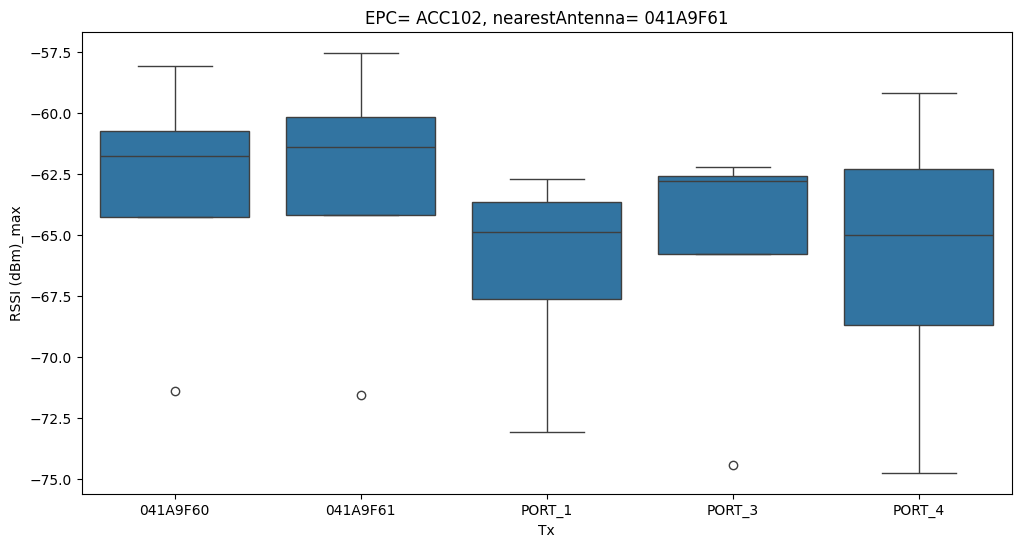

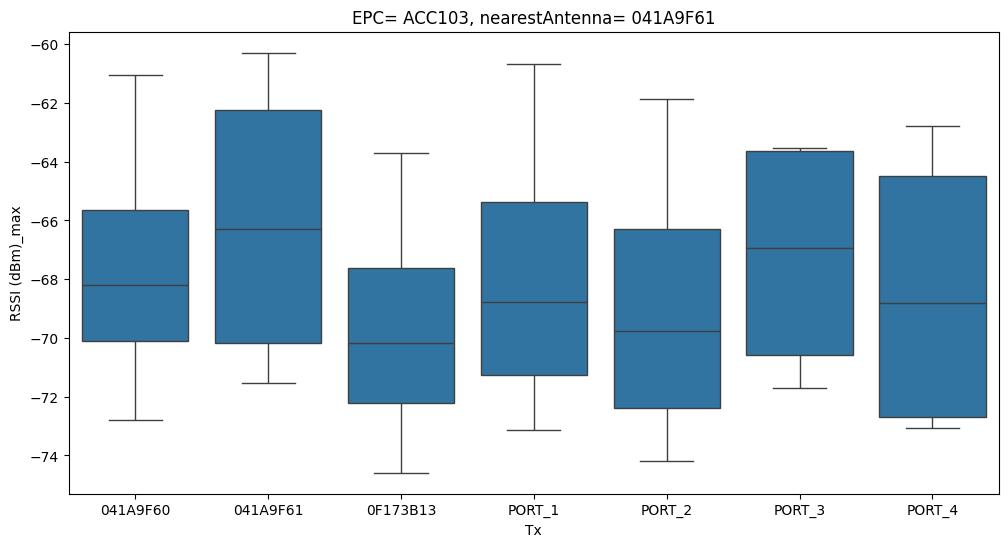

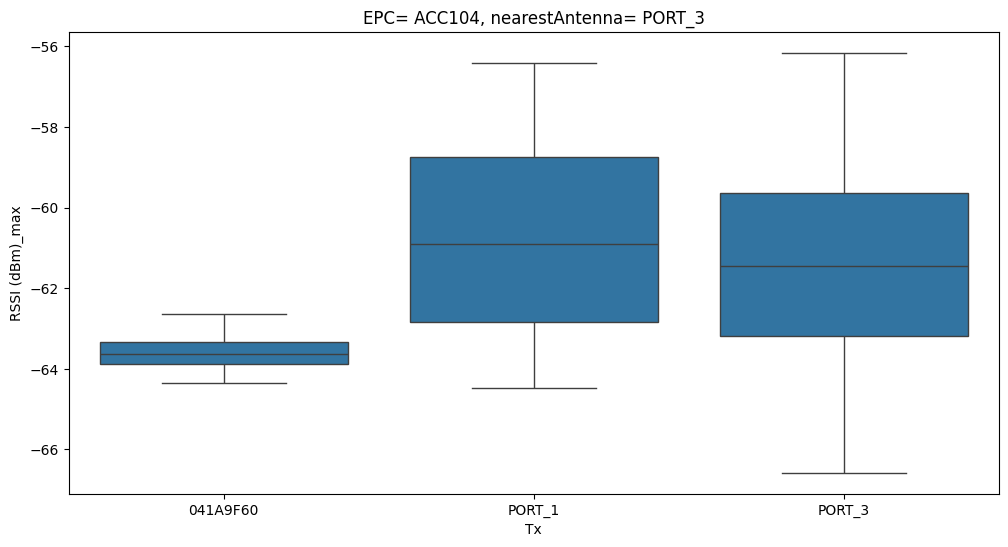

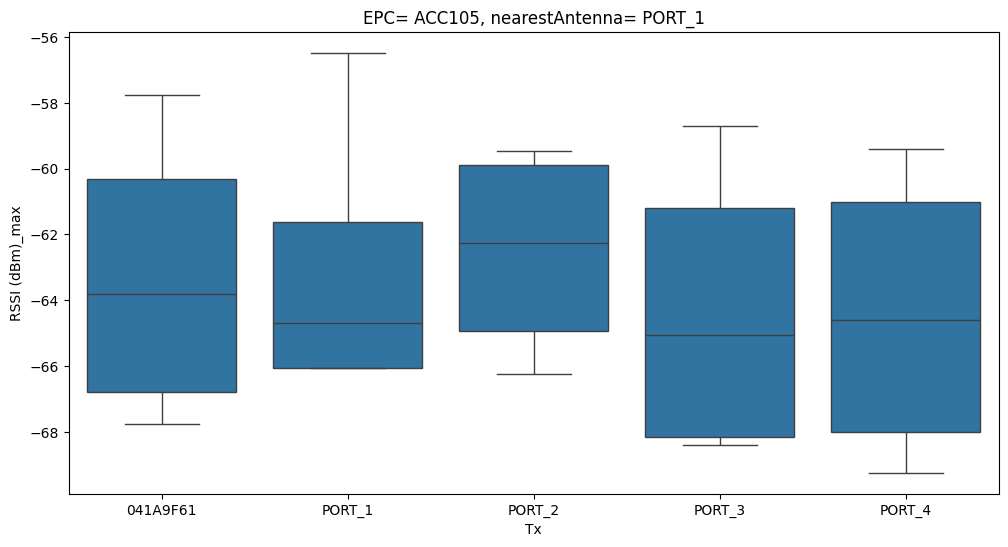

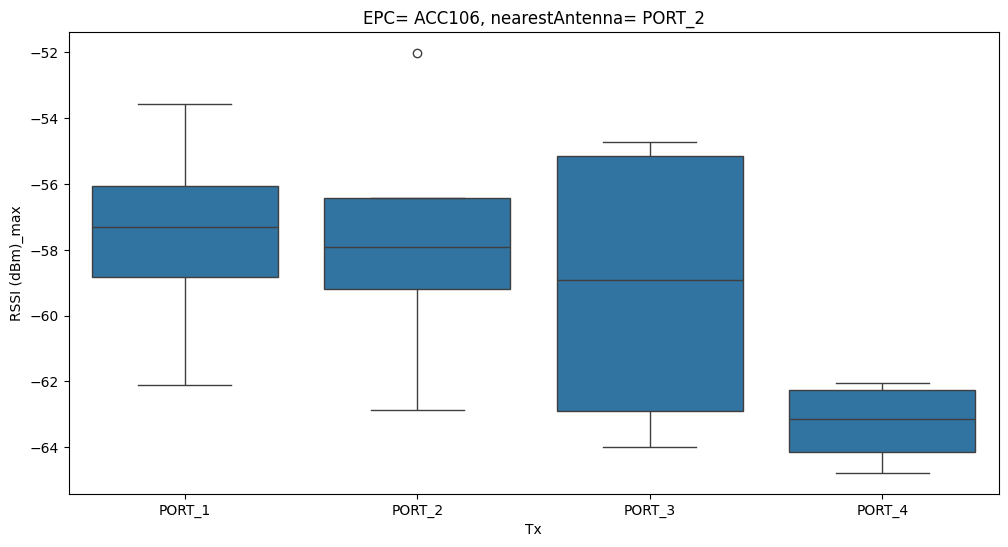

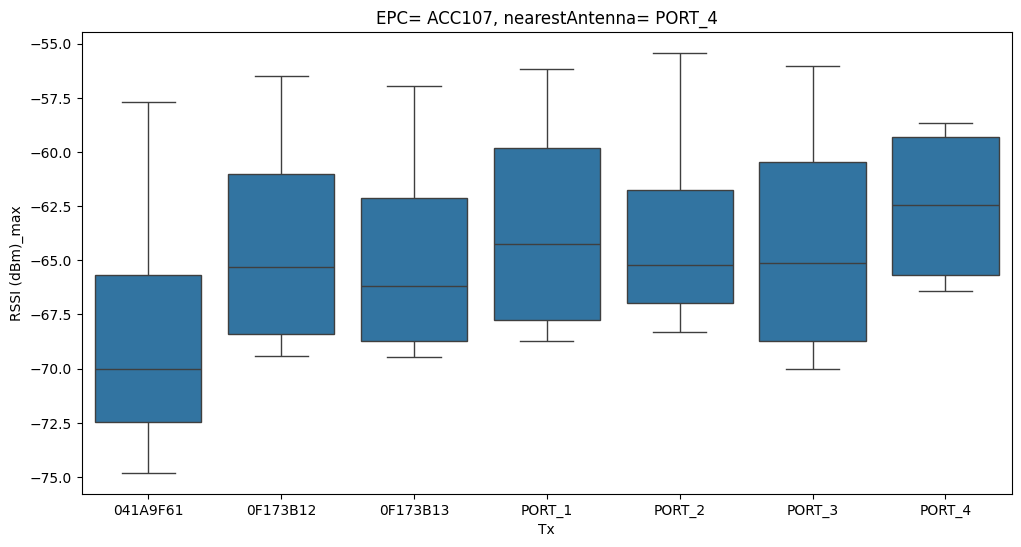

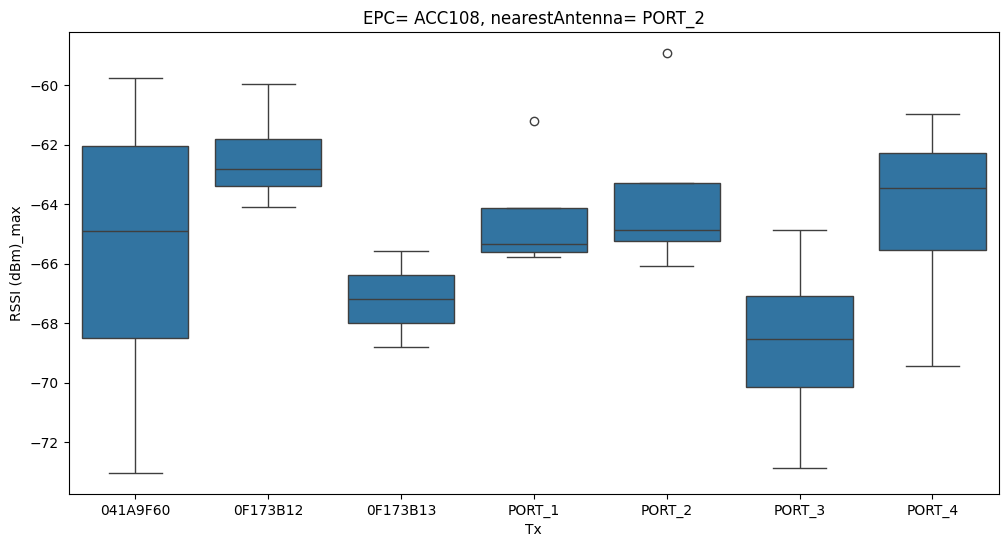

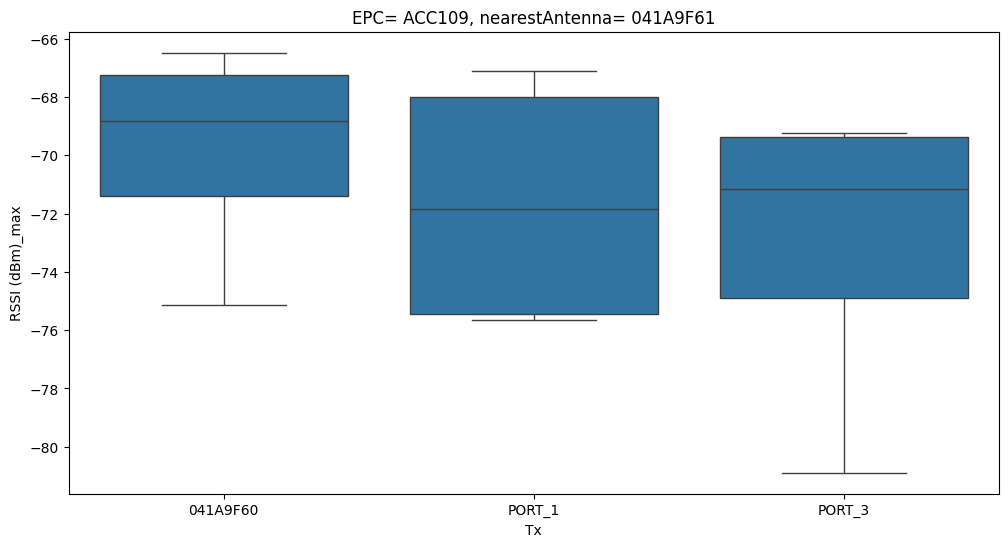

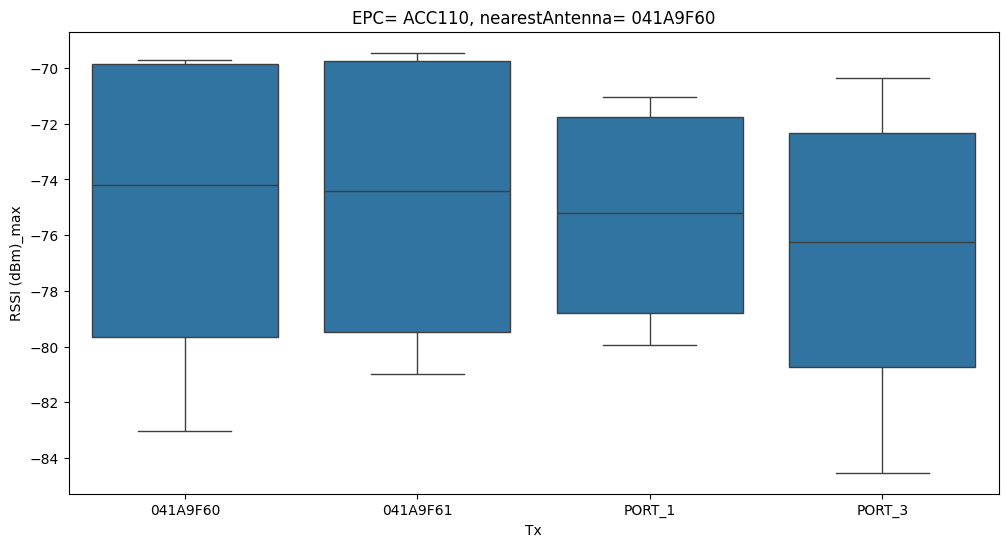

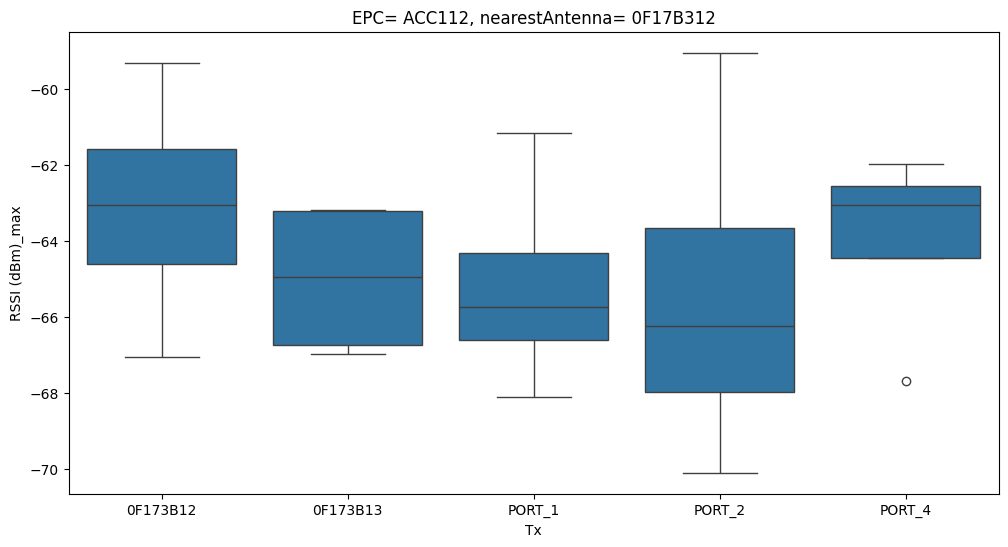

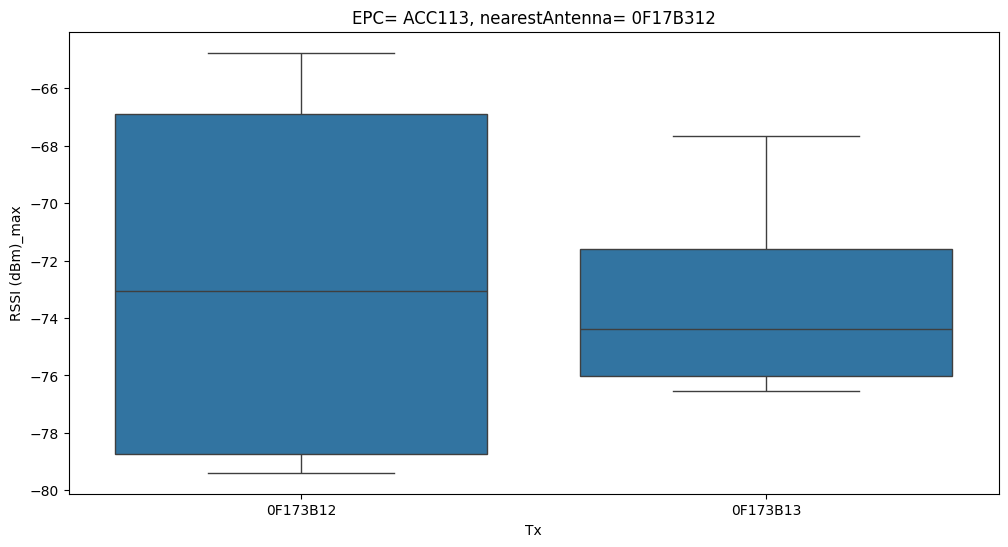

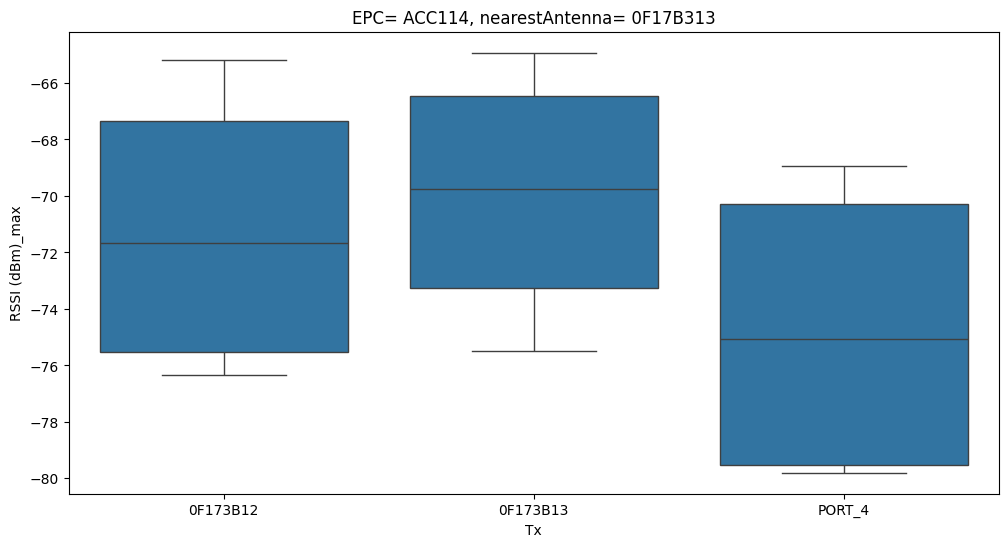

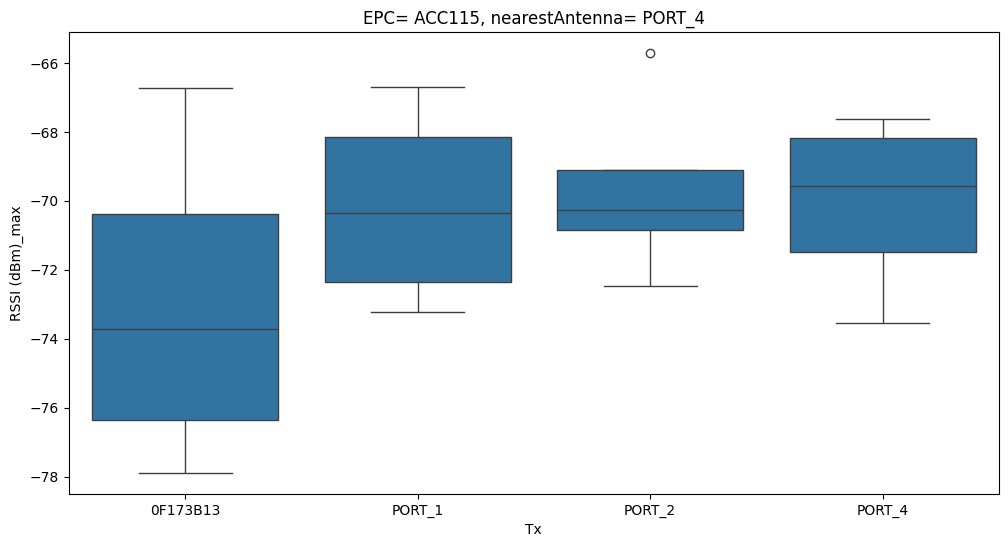

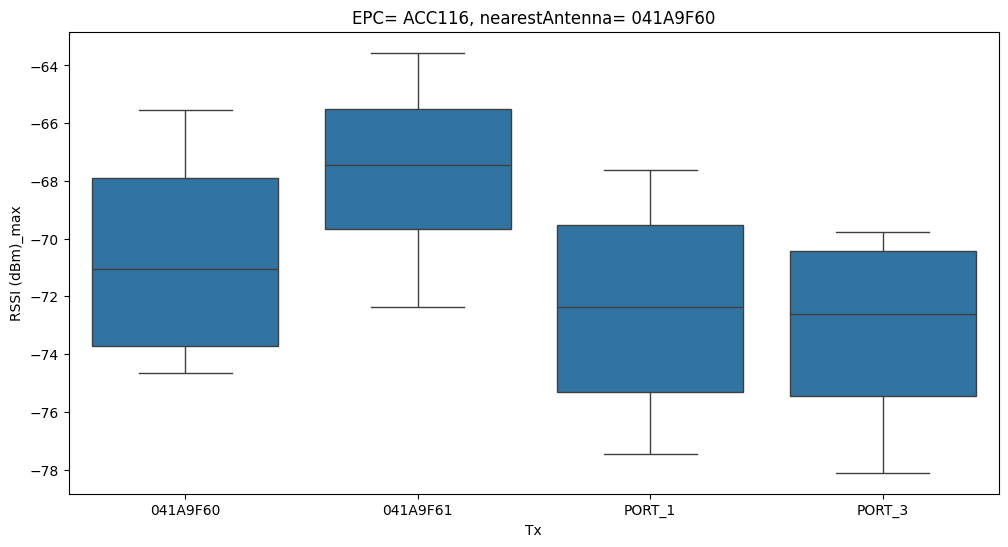

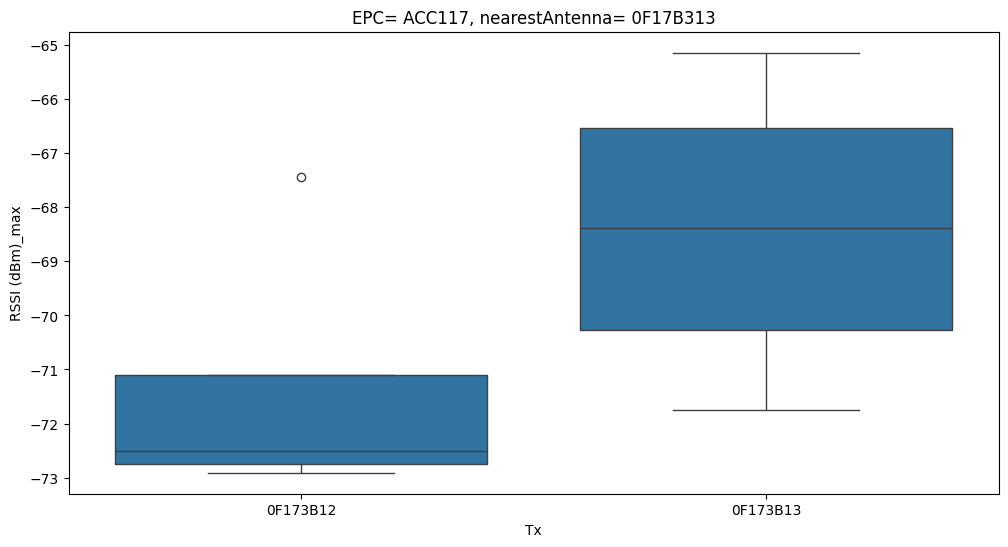

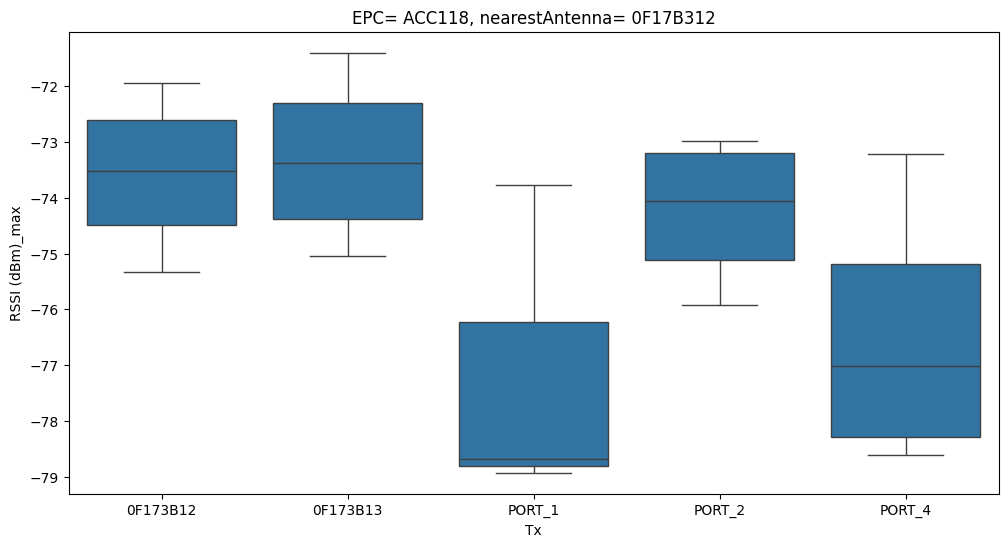

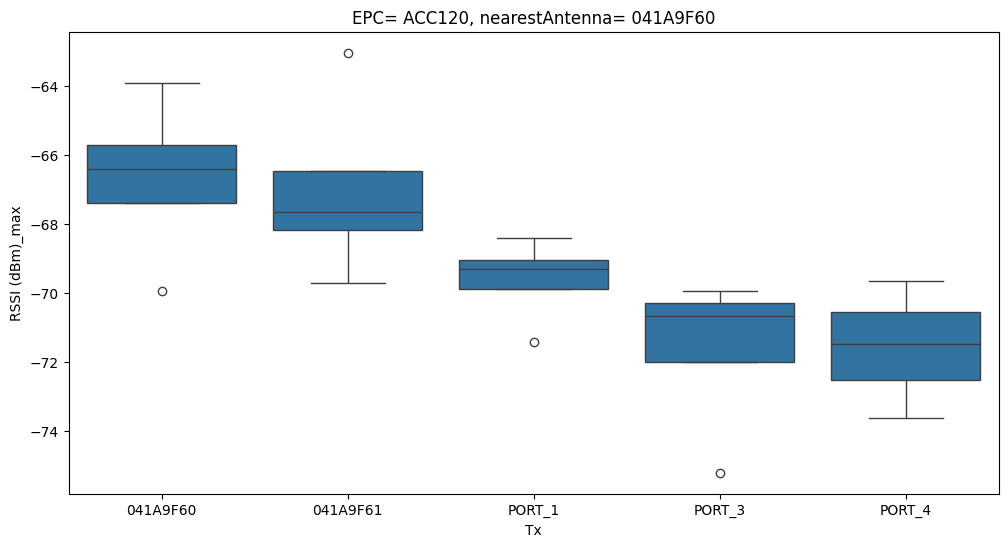

/tmp/ipython-input-1478718152.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  display.groupby('EPC').apply(func)


""


In [57]:
def func(df):
  EPC = df['EPC'].values[0]
  nearestAntenna = Actuals [Actuals['EPC']==EPC]['nearestAnt'].values[0]
  plt.figure(figsize=(12,6))
  sns.boxplot(data=df, x='Tx', y='RSSI (dBm)_max')
  plt.title(f'EPC= {EPC}, nearestAntenna= {nearestAntenna}')
  plt.show()
display.groupby('EPC').apply(func)

# sanity check statistics tags

In [58]:
tags.shape

(47280, 24)

In [59]:
tags.groupby('Tx').size()

,0
Tx,
041A9F60,4256
041A9F61,5464
0F173B12,4684
0F173B13,4982
PORT_1,9586
PORT_2,6088
PORT_3,6082
PORT_4,6138


In [60]:
tags.groupby('Tx').size().rename('Detections')

,Detections
Tx,
041A9F60,4256
041A9F61,5464
0F173B12,4684
0F173B13,4982
PORT_1,9586
PORT_2,6088
PORT_3,6082
PORT_4,6138


In [61]:
tags['EPC'].nunique(), Actuals['EPC'].nunique()

(17, 17)

## antenna with rssimax = nearest?

In [62]:
tags.columns

Index(['run', 'EPC', 'datestamp', 'Tx', 'Rx', 'RSSI (dBm)', 'RSSI', 'EPC_sf',
       'slot_id', 'slotStart', 'x', 'y', 'z', 'actual', 'ConfID', 'D_041A9F60',
       'D_041A9F61', 'D_0F17B312', 'D_0F17B313', 'D_PORT_1', 'D_PORT_2',
       'D_PORT_3', 'D_PORT_4', 'nearestAnt'],
      dtype='object')

In [64]:
ds_max = tags.groupby(['EPC','nearestAnt', 'Tx']) ['RSSI (dBm)'].max().rename('RSSI (dBm)_max').reset_index(drop=False)
ds_max

,EPC,nearestAnt,Tx,RSSI (dBm)_max
0,ACC102,041A9F61,041A9F60,-58.07
1,ACC102,041A9F61,041A9F61,-57.52
2,ACC102,041A9F61,PORT_1,-62.68
3,ACC102,041A9F61,PORT_3,-62.19
4,ACC102,041A9F61,PORT_4,-59.18
...,...,...,...,...
70,ACC120,041A9F60,041A9F60,-63.93
71,ACC120,041A9F60,041A9F61,-63.04
72,ACC120,041A9F60,PORT_1,-68.40
73,ACC120,041A9F60,PORT_3,-69.96


In [65]:
(ds_max['nearestAnt']==ds_max['Tx']).mean()

np.float64(0.14666666666666667)

# ds

## tags_sf

In [129]:
index_pivot=['run', 'EPC', 'datestamp']
columns_pivot = ['Tx', 'Rx']
# columns_pivot = ['Tx']
value = 'RSSI'
fill_value = 0
aggfunc_list = ['max']

tags_sf = pd.pivot_table(tags, index=index_pivot, columns=columns_pivot, values=['RSSI'], fill_value=0)
Xcols_tags_sf = [[str(y) for y in x] for x in tags_sf.columns]
Xcols_tags_sf = ['_'.join(x) for x in Xcols_tags_sf]
tags_sf.columns = Xcols_tags_sf

# simultaneous Rx
# tags_sf['Delta1_2'] = tags_sf['RSSI_1_1'] - tags_sf['RSSI_1_2']
# tags_sf['Delta1_3'] = tags_sf['RSSI_1_1'] - tags_sf['RSSI_1_3']
# tags_sf['Delta1_4'] = tags_sf['RSSI_1_1'] - tags_sf['RSSI_1_4']

# tags_sf['Delta2_1'] = tags_sf['RSSI_2_2'] - tags_sf['RSSI_2_1']
# tags_sf['Delta2_3'] = tags_sf['RSSI_2_2'] - tags_sf['RSSI_2_3']
# tags_sf['Delta2_4'] = tags_sf['RSSI_2_2'] - tags_sf['RSSI_2_4']

# tags_sf['Delta3_1'] = tags_sf['RSSI_3_3'] - tags_sf['RSSI_3_1']
# tags_sf['Delta3_2'] = tags_sf['RSSI_3_3'] - tags_sf['RSSI_3_2']
# tags_sf['Delta3_4'] = tags_sf['RSSI_3_3'] - tags_sf['RSSI_3_4']

# tags_sf['Delta4_1'] = tags_sf['RSSI_4_4'] - tags_sf['RSSI_4_1']
# tags_sf['Delta4_2'] = tags_sf['RSSI_4_4'] - tags_sf['RSSI_4_2']
# tags_sf['Delta4_3'] = tags_sf['RSSI_4_4'] - tags_sf['RSSI_4_3']

Xcols_tags_sf = tags_sf.columns
tags_sf = tags_sf.reset_index(drop=False)
tags_sf.head()

,run,EPC,datestamp,RSSI_041A9F60_PORT_1,RSSI_041A9F60_PORT_2,RSSI_041A9F60_PORT_3,RSSI_041A9F60_PORT_4,RSSI_041A9F61_PORT_1,RSSI_041A9F61_PORT_2,RSSI_041A9F61_PORT_3,...,RSSI_PORT_2_PORT_3,RSSI_PORT_2_PORT_4,RSSI_PORT_3_PORT_1,RSSI_PORT_3_PORT_2,RSSI_PORT_3_PORT_3,RSSI_PORT_3_PORT_4,RSSI_PORT_4_PORT_1,RSSI_PORT_4_PORT_2,RSSI_PORT_4_PORT_3,RSSI_PORT_4_PORT_4
0,2025-12-10 17:33:03,ACC102,2025-12-10 17:33:02.715,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.331894,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.000000
1,2025-12-10 17:33:03,ACC102,2025-12-10 17:33:02.756,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.232274,0.31989,0.0,0.0,0.000000,0.000000
2,2025-12-10 17:33:03,ACC102,2025-12-10 17:33:02.899,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.469894,0.094842
3,2025-12-10 17:33:03,ACC102,2025-12-10 17:33:03.437,0.528445,0.0,0.114551,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.000000
4,2025-12-10 17:33:03,ACC102,2025-12-10 17:33:03.536,0.000000,0.0,0.000000,0.0,0.346737,0.0,0.074473,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.000000


In [130]:
Xcols_tags_sf

Index(['RSSI_041A9F60_PORT_1', 'RSSI_041A9F60_PORT_2', 'RSSI_041A9F60_PORT_3',
       'RSSI_041A9F60_PORT_4', 'RSSI_041A9F61_PORT_1', 'RSSI_041A9F61_PORT_2',
       'RSSI_041A9F61_PORT_3', 'RSSI_041A9F61_PORT_4', 'RSSI_0F173B12_PORT_1',
       'RSSI_0F173B12_PORT_2', 'RSSI_0F173B12_PORT_3', 'RSSI_0F173B12_PORT_4',
       'RSSI_0F173B13_PORT_1', 'RSSI_0F173B13_PORT_2', 'RSSI_0F173B13_PORT_3',
       'RSSI_0F173B13_PORT_4', 'RSSI_PORT_1_PORT_1', 'RSSI_PORT_1_PORT_2',
       'RSSI_PORT_1_PORT_3', 'RSSI_PORT_1_PORT_4', 'RSSI_PORT_2_PORT_1',
       'RSSI_PORT_2_PORT_2', 'RSSI_PORT_2_PORT_3', 'RSSI_PORT_2_PORT_4',
       'RSSI_PORT_3_PORT_1', 'RSSI_PORT_3_PORT_2', 'RSSI_PORT_3_PORT_3',
       'RSSI_PORT_3_PORT_4', 'RSSI_PORT_4_PORT_1', 'RSSI_PORT_4_PORT_2',
       'RSSI_PORT_4_PORT_3', 'RSSI_PORT_4_PORT_4'],
      dtype='object')

In [147]:
index_pivot=['run', 'EPC']
columns_pivot=[]


fill_value = 0
aggfunc_list = [max, min, np.mean, len]
# aggfunc_list = [max, min]

ds = pd.pivot_table(tags_sf,  index=index_pivot, columns = columns_pivot, values=Xcols_tags_sf, fill_value=0, aggfunc=aggfunc_list)
ds.head()
Xcols_ds = ['_'.join([str(y) for y in x]) for x in ds.columns]
ds.columns = Xcols_ds
ds = ds.reset_index(drop=False)
ds.head()

/tmp/ipython-input-3163083551.py:9: FutureWarning: The provided callable <built-in function max> is currently using DataFrameGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  ds = pd.pivot_table(tags_sf,  index=index_pivot, columns = columns_pivot, values=Xcols_tags_sf, fill_value=0, aggfunc=aggfunc_list)
/tmp/ipython-input-3163083551.py:9: FutureWarning: The provided callable <built-in function min> is currently using DataFrameGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  ds = pd.pivot_table(tags_sf,  index=index_pivot, columns = columns_pivot, values=Xcols_tags_sf, fill_value=0, aggfunc=aggfunc_list)
/tmp/ipython-input-3163083551.py:9: FutureWarning: The provided callable <function mean at 0x7971f3a03880> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided

,run,EPC,max_RSSI_041A9F60_PORT_1,max_RSSI_041A9F60_PORT_2,max_RSSI_041A9F60_PORT_3,max_RSSI_041A9F60_PORT_4,max_RSSI_041A9F61_PORT_1,max_RSSI_041A9F61_PORT_2,max_RSSI_041A9F61_PORT_3,max_RSSI_041A9F61_PORT_4,...,len_RSSI_PORT_2_PORT_3,len_RSSI_PORT_2_PORT_4,len_RSSI_PORT_3_PORT_1,len_RSSI_PORT_3_PORT_2,len_RSSI_PORT_3_PORT_3,len_RSSI_PORT_3_PORT_4,len_RSSI_PORT_4_PORT_1,len_RSSI_PORT_4_PORT_2,len_RSSI_PORT_4_PORT_3,len_RSSI_PORT_4_PORT_4
0,2025-12-10 17:33:03,ACC102,0.651628,0.072277,1.559553,0.685488,0.783430,0.069984,1.770109,0.669885,...,2249,2249,2249,2249,2249,2249,2249,2249,2249,2249
1,2025-12-10 17:33:03,ACC103,0.191867,0.052481,0.785236,0.119950,0.516416,0.069984,0.935406,0.106905,...,2188,2188,2188,2188,2188,2188,2188,2188,2188,2188
2,2025-12-10 17:33:03,ACC104,0.545758,0.440555,0.366438,0.424620,0.000000,0.000000,0.000000,0.000000,...,934,934,934,934,934,934,934,934,934,934
3,2025-12-10 17:33:03,ACC105,0.000000,0.000000,0.000000,0.000000,0.767361,1.674943,0.225944,0.167494,...,2187,2187,2187,2187,2187,2187,2187,2187,2187,2187
4,2025-12-10 17:33:03,ACC106,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1786,1786,1786,1786,1786,1786,1786,1786,1786,1786


In [148]:
len(Xcols_ds)

128

In [149]:
Actuals

,EPC,x,y,z,actual,ConfID,D_041A9F60,D_041A9F61,D_0F17B312,D_0F17B313,D_PORT_1,D_PORT_2,D_PORT_3,D_PORT_4,nearestAnt
0,ACC102,6.7,11.7,5.3,P,2025-12-10,8.370185,7.080254,31.697003,31.807389,14.725828,22.854978,15.597436,23.244139,041A9F61
1,ACC103,11.0,18.3,8.6,P,2025-12-10,11.719215,6.854925,29.090205,27.272880,10.576862,18.646447,15.600641,21.017374,041A9F61
2,ACC104,15.4,7.2,6.9,P,2025-12-10,7.964923,9.687621,22.359338,23.759840,9.387758,15.172673,7.226341,14.092196,PORT_3
3,ACC105,21.2,10.4,2.1,P,2025-12-10,15.820240,15.725457,19.951441,20.254629,11.543396,13.139635,12.298780,13.366750,PORT_1
4,ACC106,26.1,18.1,4.6,P,2025-12-10,21.394158,19.301295,18.805584,15.471910,12.052386,10.257680,16.904733,14.142136,PORT_2
5,ACC107,29.4,6.9,7.6,P,2025-12-10,20.654782,21.519061,9.604166,12.003749,13.267630,7.942921,12.111978,5.554278,PORT_4
6,ACC108,27.9,19.6,6.8,P,2025-12-10,23.009998,20.699034,17.986106,13.498518,12.573385,9.355747,17.976095,14.134002,PORT_2
7,ACC109,0.0,10.4,5.6,P,2025-12-10,11.600431,11.284503,37.826049,38.283678,20.709901,29.237647,20.735236,29.268071,041A9F61
8,ACC110,10.4,1.5,5.6,P,2025-12-10,8.580210,12.829263,27.743107,30.480978,16.396036,22.244325,11.880236,19.930128,041A9F60
9,ACC112,35.1,8.1,5.0,P,2025-12-10,26.818464,27.273797,9.297849,10.726602,18.644570,11.483031,18.475118,10.697663,0F17B312


In [150]:
ds[:1]

,run,EPC,max_RSSI_041A9F60_PORT_1,max_RSSI_041A9F60_PORT_2,max_RSSI_041A9F60_PORT_3,max_RSSI_041A9F60_PORT_4,max_RSSI_041A9F61_PORT_1,max_RSSI_041A9F61_PORT_2,max_RSSI_041A9F61_PORT_3,max_RSSI_041A9F61_PORT_4,...,len_RSSI_PORT_2_PORT_3,len_RSSI_PORT_2_PORT_4,len_RSSI_PORT_3_PORT_1,len_RSSI_PORT_3_PORT_2,len_RSSI_PORT_3_PORT_3,len_RSSI_PORT_3_PORT_4,len_RSSI_PORT_4_PORT_1,len_RSSI_PORT_4_PORT_2,len_RSSI_PORT_4_PORT_3,len_RSSI_PORT_4_PORT_4
0,2025-12-10 17:33:03,ACC102,0.651628,0.072277,1.559553,0.685488,0.78343,0.069984,1.770109,0.669885,...,2249,2249,2249,2249,2249,2249,2249,2249,2249,2249


In [151]:
ds = pd.merge(ds, Actuals, on='EPC')
ds.head()

,run,EPC,max_RSSI_041A9F60_PORT_1,max_RSSI_041A9F60_PORT_2,max_RSSI_041A9F60_PORT_3,max_RSSI_041A9F60_PORT_4,max_RSSI_041A9F61_PORT_1,max_RSSI_041A9F61_PORT_2,max_RSSI_041A9F61_PORT_3,max_RSSI_041A9F61_PORT_4,...,ConfID,D_041A9F60,D_041A9F61,D_0F17B312,D_0F17B313,D_PORT_1,D_PORT_2,D_PORT_3,D_PORT_4,nearestAnt
0,2025-12-10 17:33:03,ACC102,0.651628,0.072277,1.559553,0.685488,0.783430,0.069984,1.770109,0.669885,...,2025-12-10,8.370185,7.080254,31.697003,31.807389,14.725828,22.854978,15.597436,23.244139,041A9F61
1,2025-12-10 17:33:03,ACC103,0.191867,0.052481,0.785236,0.119950,0.516416,0.069984,0.935406,0.106905,...,2025-12-10,11.719215,6.854925,29.090205,27.272880,10.576862,18.646447,15.600641,21.017374,041A9F61
2,2025-12-10 17:33:03,ACC104,0.545758,0.440555,0.366438,0.424620,0.000000,0.000000,0.000000,0.000000,...,2025-12-10,7.964923,9.687621,22.359338,23.759840,9.387758,15.172673,7.226341,14.092196,PORT_3
3,2025-12-10 17:33:03,ACC105,0.000000,0.000000,0.000000,0.000000,0.767361,1.674943,0.225944,0.167494,...,2025-12-10,15.820240,15.725457,19.951441,20.254629,11.543396,13.139635,12.298780,13.366750,PORT_1
4,2025-12-10 17:33:03,ACC106,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2025-12-10,21.394158,19.301295,18.805584,15.471910,12.052386,10.257680,16.904733,14.142136,PORT_2


In [152]:
ds.columns

Index(['run', 'EPC', 'max_RSSI_041A9F60_PORT_1', 'max_RSSI_041A9F60_PORT_2',
       'max_RSSI_041A9F60_PORT_3', 'max_RSSI_041A9F60_PORT_4',
       'max_RSSI_041A9F61_PORT_1', 'max_RSSI_041A9F61_PORT_2',
       'max_RSSI_041A9F61_PORT_3', 'max_RSSI_041A9F61_PORT_4',
       ...
       'ConfID', 'D_041A9F60', 'D_041A9F61', 'D_0F17B312', 'D_0F17B313',
       'D_PORT_1', 'D_PORT_2', 'D_PORT_3', 'D_PORT_4', 'nearestAnt'],
      dtype='object', length=144)

In [153]:
ds.shape

(17, 144)

# **Regression Added by Uzair**


In [154]:
# Regression (RF, ET, GB, KNN, Ridge, DecisionTree, NN)

from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


X_reg = ds[Xcols_ds].values
y_reg = ds[['x', 'y', 'z']].values
idx_all = ds.index.to_numpy()   # keep track of original indices

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_reg, y_reg, idx_all,
    test_size=0.2,
    random_state=0
)


# Define candidate regressors

regressors = {
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=0),
    "ExtraTrees": ExtraTreesRegressor(n_estimators=200, random_state=0),
    "GradientBoosting": GradientBoostingRegressor(random_state=0),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "Ridge": Ridge(alpha=1.0),
    "DecisionTree": DecisionTreeRegressor(random_state=0),
    "NN": MLPRegressor(
        hidden_layer_sizes=(64, 64),
        activation='relu',
        random_state=0,
        max_iter=1000,
        early_stopping=True
    ),
}

reg_results = {}    # RMSE per model
reg_errors = {}     # per-sample 3D distance error per model
y_pred_store = {}   # store predictions per model
best_model = None   # trained RandomForest model


for name, base_reg in regressors.items():
    model = MultiOutputRegressor(base_reg)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # 3D RMSE on (x, y, z)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    reg_results[name] = rmse

    # per-sample Euclidean distance in 3D
    dists = np.linalg.norm(y_pred - y_test, axis=1)
    reg_errors[name] = dists

    # store predictions for later analysis (Task 3 & 4)
    y_pred_store[name] = y_pred

    print(
        f"{name}: 3D RMSE = {rmse:.3f} m, "
        f"mean |error| = {dists.mean():.3f} m, "
        f"median |error| = {np.median(dists):.3f} m"
    )

    # keep RandomForest as final model if it is good otherwise change it
    if name == "RandomForest":
        best_model = model

reg_results


RandomForest: 3D RMSE = 5.755 m, mean |error| = 9.555 m, median |error| = 10.403 m
ExtraTrees: 3D RMSE = 5.260 m, mean |error| = 8.850 m, median |error| = 7.922 m
GradientBoosting: 3D RMSE = 5.818 m, mean |error| = 9.839 m, median |error| = 9.861 m
KNN: 3D RMSE = 10.028 m, mean |error| = 16.636 m, median |error| = 15.604 m
Ridge: 3D RMSE = 7.695 m, mean |error| = 12.512 m, median |error| = 13.893 m
DecisionTree: 3D RMSE = 9.435 m, mean |error| = 15.946 m, median |error| = 16.195 m
NN: 3D RMSE = 14.156 m, mean |error| = 22.554 m, median |error| = 23.987 m


{'RandomForest': np.float64(5.755114875410101),
 'ExtraTrees': np.float64(5.259781966330287),
 'GradientBoosting': np.float64(5.818210917739566),
 'KNN': np.float64(10.027743182458021),
 'Ridge': np.float64(7.694683589966484),
 'DecisionTree': np.float64(9.434952746746182),
 'NN': np.float64(14.155690409684096)}

In [ ]:
import numpy as np

# Antennas for the 2m square (case 1)
antennas_case1 = np.array([
    # for case 2 and 3
    [ 0.0, -1.0, 0.0],  # South
    [ 1.0,  0.0, 0.0],  # East
    [ 0.0,  1.0, 0.0],  # North
    [-1.0,  0.0, 0.0],  # West
    # for case 1
    # [-1.0, -1.0, 0.0],   # A1
    # [ 1.0, -1.0, 0.0],   # A2
    # [ 1.0,  1.0, 0.0],   # A3
    # [-1.0,  1.0, 0.0],   # A4
])

def nearest_antenna(points, antennas):
    d = np.linalg.norm(points[:,None,:] - antennas[None,:,:], axis=2)
    return np.argmin(d, axis=1)

# TRUE nearest antennas
true_nearest = nearest_antenna(y_test, antennas_case1)

# PRED nearest antennas for RandomForest only
rf_pred = y_pred_store["RandomForest"]
pred_nearest = nearest_antenna(rf_pred, antennas_case1)

# Zone accuracy
zone_accuracy = np.mean(true_nearest == pred_nearest)

print(f"RF – Antenna Zone Accuracy: {zone_accuracy*100:.2f}%")


RF – Antenna Zone Accuracy: 75.00%


In [ ]:
# Building a DataFrame with test errors for a given model

def build_error_df(model_name="RandomForest"):
    """
    Returns a DataFrame with, for each test sample:
    - original ds index
    - true (x,y,z)
    - predicted (x,y,z)
    - 3D error (Euclidean distance)
    """
    if model_name not in y_pred_store:
        raise ValueError(f"Unknown model '{model_name}'. Available: {list(y_pred_store.keys())}")

    y_pred = y_pred_store[model_name]
    dists = reg_errors[model_name]

    # Build DataFrame
    df_err = pd.DataFrame({
        "ds_index": idx_test,
        "x_true": y_test[:, 0],
        "y_true": y_test[:, 1],
        "z_true": y_test[:, 2],
        "x_pred": y_pred[:, 0],
        "y_pred": y_pred[:, 1],
        "z_pred": y_pred[:, 2],
        "error_3D": dists,
    })

    # Sort by descending error
    df_err = df_err.sort_values(by="error_3D", ascending=False).reset_index(drop=True)
    return df_err

# for RandomForest:
# df_err_rf = build_error_df("RandomForest")
# df_err_rf.head()

# for NN:
df_err_nn = build_error_df("NN")
df_err_nn.head()


,ds_index,x_true,y_true,z_true,x_pred,y_pred,z_pred,error_3D
0,1,11.0,18.3,8.6,102.210718,73.541096,0.745897,106.923621
1,9,35.1,8.1,5.0,88.220684,63.622271,1.222751,76.933720
2,6,27.9,19.6,6.8,84.753372,61.111604,1.133692,70.623128
3,8,10.4,1.5,5.6,48.772645,35.091968,0.368223,51.266477


In [ ]:
#Inspecting worst-error samples for a given model

def show_worst_samples(model_name="RandomForest", k=5):
    df_err = build_error_df(model_name)
    worst = df_err.head(k)
    print(f"Worst {k} samples for model: {model_name}")
    display(worst)


    cols_to_show = ["EPC", "run"] if all(c in ds.columns for c in ["EPC", "run"]) else []
    if cols_to_show:
        print("\nWith original ds info:")
        display(
            worst.merge(ds[cols_to_show], left_on="ds_index", right_index=True, how="left")
        )

# show worst 5 for RandomForest
# show_worst_samples("RandomForest", k=5)
# show worst 5 for NN
show_worst_samples("NN", k=5)


Worst 5 samples for model: NN


TypeError: 'DataFrame' object is not callable

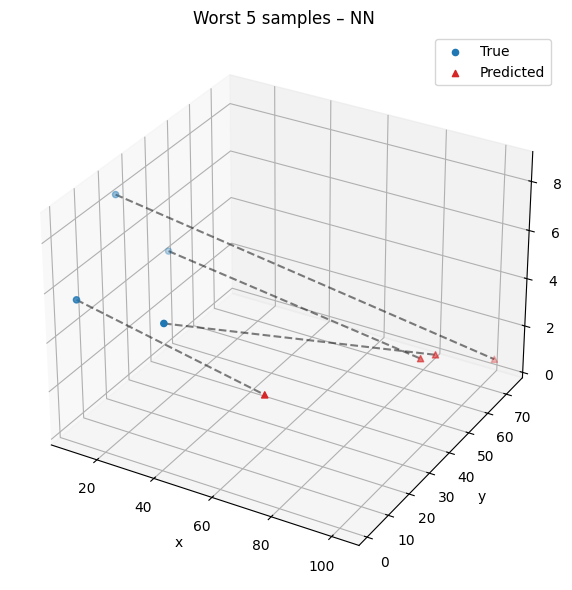

In [ ]:
# 3D scatter for worst samples (true vs pred positions) to check the error added for only refrence

from mpl_toolkits.mplot3d import Axes3D

def plot_worst_samples_3D(model_name="RandomForest", k=5):
    df_err = build_error_df(model_name)
    worst = df_err.head(k)

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # True positions
    ax.scatter(
        worst["x_true"], worst["y_true"], worst["z_true"],
        c="tab:blue", marker="o", label="True"
    )
    # Predicted positions
    ax.scatter(
        worst["x_pred"], worst["y_pred"], worst["z_pred"],
        c="tab:red", marker="^", label="Predicted"
    )

    for _, row in worst.iterrows():
        ax.plot(
            [row["x_true"], row["x_pred"]],
            [row["y_true"], row["y_pred"]],
            [row["z_true"], row["z_pred"]],
            "k--", alpha=0.5
        )

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.set_title(f"Worst {k} samples – {model_name}")
    ax.legend()
    plt.tight_layout()
    plt.show()

# PLoting for NN
plot_worst_samples_3D("NN", k=5)


In [ ]:
# #Cell-based granularity analysis (2m, 1m, 0.5m)

# def cell_accuracy(y_true, y_pred, cell_size):
#     """
#     Compute % of samples where true and predicted positions
#     fall into the same cell on a grid with given cell_size (in meters).
#     """
#     y_true = np.asarray(y_true)
#     y_pred = np.asarray(y_pred)


#     true_snapped = np.round(y_true / cell_size) * cell_size
#     pred_snapped = np.round(y_pred / cell_size) * cell_size


#     same_cell = np.all(true_snapped == pred_snapped, axis=1)
#     return same_cell.mean()

# def report_cell_accuracies(model_name="RandomForest", cell_sizes=(2.0, 1.0, 0.5)):
#     y_pred = y_pred_store[model_name]
#     print(f"Cell accuracy for model: {model_name}")
#     for G in cell_sizes:
#         acc = cell_accuracy(y_test, y_pred, G)
#         print(f"  grid {G:.2f} m: {acc*100:.1f}% of test points in correct cell")

# report_cell_accuracies("RandomForest", cell_sizes=(2.0, 1.0, 0.5))
# report_cell_accuracies("NN",          cell_sizes=(2.0, 1.0, 0.5))


In [ ]:

# radii = [0.5, 1.0, 1.5, 2.0]

# for name, dists in reg_errors.items():
#     print(f"\n{name}:")
#     for R in radii:
#         frac = (dists <= R).mean()
#         print(f"  within {R:.1f} m: {frac*100:.1f}% of test points")


# RandomForest

In [155]:
ds_pick = ds.copy()
Xcols_ds_pick = Xcols_ds

In [199]:
Values_xyz = ['x', 'y', 'z']
Values_D_ant = [x for x in ds_pick.columns if x.startswith('D_')]
Values_all = Values_xyz + Values_D_ant

Values_pick = Values_xyz
# Values_pick = Values_D_ant
# Values_pick = Values_all

Values_pick_pred = [x+'_pred' for x in Values_pick]

In [200]:
X = ds_pick[Xcols_ds_pick]
y = ds_pick[Values_pick].values

In [201]:
from sklearn.metrics import mean_squared_error
clf = RandomForestRegressor()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
clf.fit(X_train, y_train)
y_pred =  clf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse= np.sqrt(mse)
rmse
# np.sqrt(pd.Series([(x[0]**2+x[1]**2+x[2]**2)  for x in (y_test-y_pred)]).mean())

np.float64(5.796876960916113)

In [202]:
ds_shuffle = ds_pick.sample(frac=1).reset_index(drop=True)
for ds_test in np.array_split(ds_shuffle, 4):
  idx_test = ds_test.index
  idx_train = [x for x in ds_shuffle.index if x not in idx_test]
  ds_train = ds_shuffle.loc[idx_train]
  X_train = ds_train[Xcols_ds_pick]
  y_train = ds_train[Values_pick]
  X_test = ds_test[Xcols_ds_pick]
  y_test = ds_test[Values_pick]
  clf = RandomForestRegressor()
  clf.fit(X_train, y_train)
  y_pred =  clf.predict(X_test)
  ds_shuffle.loc[idx_test, Values_pick_pred] = y_pred


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [203]:
mse = mean_squared_error(ds_shuffle[Values_pick], ds_shuffle[Values_pick_pred])
rmse = np.sqrt(mse)
rmse

np.float64(6.098848431964711)

In [204]:
# Cols=['Dx', 'Dy', 'Dz']
Errors = pd.DataFrame([x for x in (ds_shuffle[Values_pick].values-ds_shuffle[Values_pick_pred].values) ], columns=Cols)
Errors
np.sqrt((Errors[Cols]**2).mean())


,0
Dx,7.484198
Dy,7.273083
Dz,1.636125


In [145]:
np.sqrt(mean_squared_error(ds_shuffle[Values_pick], ds_shuffle[Values_pick_pred], multioutput='raw_values') )

array([7.96320984, 7.31525483, 1.76272898])

In [146]:
np.sqrt((Errors[Cols]**2).mean().mean())

np.float64(6.325421661524108)

In [105]:
Errors = Errors.join(ds_shuffle['EPC']) [['EPC', 'Dx', 'Dy', 'Dz']]
Errors

,EPC,Dx,Dy,Dz
0,ACC102,-5.214,0.283,-2.109
1,ACC117,10.766,14.079,0.548
2,ACC109,-15.500,4.422,-0.922
3,ACC105,-1.458,-1.966,-4.291
4,ACC118,6.918,-4.026,1.284
5,ACC107,-0.975,-6.462,1.643
6,ACC103,-4.753,9.800,2.650
7,ACC116,-6.179,-1.979,1.150
8,ACC112,1.288,-4.028,-1.200
9,ACC108,6.117,11.398,0.753


In [107]:
EPC_loc = pd.merge(ds_shuffle [['EPC'] + Values_pick + Values_pick_pred  ], Errors)
EPC_loc

,EPC,x,y,z,x_pred,y_pred,z_pred,Dx,Dy,Dz
0,ACC102,6.7,11.7,5.3,11.914,11.417,7.409,-5.214,0.283,-2.109
1,ACC117,44.5,19.6,6.4,33.734,5.521,5.852,10.766,14.079,0.548
2,ACC109,0.0,10.4,5.6,15.500,5.978,6.522,-15.500,4.422,-0.922
3,ACC105,21.2,10.4,2.1,22.658,12.366,6.391,-1.458,-1.966,-4.291
4,ACC118,38.3,2.0,7.2,31.382,6.026,5.916,6.918,-4.026,1.284
5,ACC107,29.4,6.9,7.6,30.375,13.362,5.957,-0.975,-6.462,1.643
6,ACC103,11.0,18.3,8.6,15.753,8.500,5.950,-4.753,9.800,2.650
7,ACC116,2.5,5.0,6.9,8.679,6.979,5.750,-6.179,-1.979,1.150
8,ACC112,35.1,8.1,5.0,33.812,12.128,6.200,1.288,-4.028,-1.200
9,ACC108,27.9,19.6,6.8,21.783,8.202,6.047,6.117,11.398,0.753


In [118]:
EPC_loc['D_err'] = [np.sqrt((x**2).sum()) for x in (EPC_loc[Values_pick].values - EPC_loc[Values_pick_pred].values)]
EPC_loc

,EPC,x,y,z,x_pred,y_pred,z_pred,Dx,Dy,Dz,D_err
0,ACC102,6.7,11.7,5.3,11.914,11.417,7.409,-5.214,0.283,-2.109,5.631498
1,ACC117,44.5,19.6,6.4,33.734,5.521,5.852,10.766,14.079,0.548,17.732042
2,ACC109,0.0,10.4,5.6,15.500,5.978,6.522,-15.500,4.422,-0.922,16.144788
3,ACC105,21.2,10.4,2.1,22.658,12.366,6.391,-1.458,-1.966,-4.291,4.940000
4,ACC118,38.3,2.0,7.2,31.382,6.026,5.916,6.918,-4.026,1.284,8.106544
5,ACC107,29.4,6.9,7.6,30.375,13.362,5.957,-0.975,-6.462,1.643,6.738510
6,ACC103,11.0,18.3,8.6,15.753,8.500,5.950,-4.753,9.800,2.650,11.209528
7,ACC116,2.5,5.0,6.9,8.679,6.979,5.750,-6.179,-1.979,1.150,6.589308
8,ACC112,35.1,8.1,5.0,33.812,12.128,6.200,1.288,-4.028,-1.200,4.395876
9,ACC108,27.9,19.6,6.8,21.783,8.202,6.047,6.117,11.398,0.753,12.957589


In [123]:
mse = mean_squared_error(ds_shuffle[Values_pick], ds_shuffle[Values_pick_pred])
rmse = np.sqrt(mse)
rmse

np.float64(5.856111133494916)

In [124]:
np.sqrt(mean_squared_error(ds_shuffle[Values_pick], ds_shuffle[Values_pick_pred], multioutput='raw_values'))

array([7.13666232, 7.00826379, 1.68356834])

In [125]:
EPC_loc['D_err'].describe()

,D_err
count,17.000000
mean,9.109420
std,4.598300
min,2.746683
25%,6.589308
50%,7.945562
75%,11.209528
max,17.980382
